In [239]:
from enc import ctoi
from collections import Counter, defaultdict
from itertools import combinations
import math

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import scipy as sp
from dataclasses import dataclass

In [2]:
def stream_diff(s1, s2):
    ds = s1 - s2
    for i, d in enumerate(ds):
        if d < 0:
            ds[i] += 27
    return ds

def cntr_entropy(counter: Counter):
    ent = 0.
    for cnt in counter.values():
        p = cnt / sum(counter.values())
        ent -= p * math.log(p)
    return ent

def entropy(data):
    if isinstance(data, Counter):
        return cntr_entropy(data)

    _, counts = np.unique(data, return_counts=True)
    probs= counts / counts.sum()
    ent = -np.sum(probs * np.log(probs))
    return ent

def encode(text):
    return np.array([ctoi[c] for c in text])

In [3]:
keys = range(4, 25)

def load_ciphers():
    ciphers = defaultdict(list)
    for key_len in keys:
        for correct in range(1, 6):
            filename = f'resources/key_{key_len}/cipher_{correct}'
            with open(filename, 'r') as f:
                ciphers[key_len].append(f.readline().strip())
    return ciphers

plains = [
    "barmiest hastes spades fevers cause wisped unconquerable tropical pythagoras rebukingly price ephedra overdecorates linked smitten trickle scanning cognize oaken casework politicize significate influenceable precontrived clockers defalcation workwomen splintery kids placidness harebrained liberalism neuronic clavierist attendees matinees prospectively bubbies longitudinal raving relaxants rigged oxygens chronologist briniest tweezes profaning abeyances fixity gulls coquetted budgerigar drooled unassertive shelter subsoiling surmounted underwear jobbed hobnailed fulfilling jaywalking testabilit",
    "denunciation chronaxy imperilment incurred defrosted protectorates committeemen refractory narcissus bridlers weathercocks occluding orchectomy syncoms beamy opticopupillary acculturation scouting headstrong tosh preconscious weekday reich saddler mercerizes saucepan bifold regenerate chit reviewable easiness brazed essentially idler dependable predicable locales rededicated cowbird kvetched confusingly airdrops dreggier privileges tempter anaerobes glistened sartorial distrustfulness papillary ughs proctoring duplexed pitas traitorously unlighted cryptographer odysseys metamer either meliorat",
    "trenched wickerwork orientation candidnesses nets opalescing pharynxes recompensive incomes shoes porcine pursue blabbered irritable ballets grabbed scything oscillogram despots disarraying curiousest crappier friending wining cypher insubmissive oceanid bowlegs voider recook parochial trop gravidly vomiting hurray friended uncontestable situate fen cyclecars gads macrocosms dhyana overruns impolite europe cynical jennet tumor noddy canted clarion opiner incurring knobbed planeload megohm dejecting campily dedicational invaluable praecoces coalescence dibbuk bustles flay acuities centimeters l",
    "angle obliquely bean mariachi walkup toilettes squib tightwads pipe extents rejoicing nectar asker dreadfuls kidnappers interstate incrusting quintessential neglecter copycat phosphatic streakier frowning phantasmagories supinates imbibers inactivates tingly deserter steerages beggared pulsator laity salvageable bestrode interning stodgily cracker excisions quanted arranges poultries sleds shortly packages apparat fledge alderwomen halvah verdi ineffectualness entrenches franchising merchantability trisaccharide limekiln sportsmanship lassitudes recidivistic locating iou wardress estrus potboi",
    "schmeering institutor hairlocks speeder composers dramatics eyeholes progressives headmaster attractant subjugator peddlery vigil dogfights pixyish comforts aretes brewage felinities salerooms reminiscent hermaphrodism simultaneous spondaics hayfork armory refashioning battering darning tapper pancaked unaffected televiewer mussiness pollbook sieved reclines restamp cohosh excludes homelier coacts refashioned loiterer prospectively encouragers biggest pasters modernity governorships crusted buttoned wallpapered enamors supervisal nervily groaning disembody communion embosoming tattles turbans ",
]
    
ciphers = load_ciphers()

In [5]:
# Entropy Start Point Analysis
# The first N characters are used to compute the entropy of diff streams
# If one of the streams shows an anomaly, we conclude that the plaintext, which the stream came from
# is the one we are looking for.

def start_entropy_analysis(N=30, threshold=0.186):
    fig, axes = plt.subplots(21, 5, figsize=(20, 30))
    working_cases = 0
    correct_cases = 0
    wrong_cases   = 0
    stds = []
    for key in keys:
        ax_row = axes[key-4]
        stds = []
        for ci, ciphertext in enumerate(ciphers[key]):
            ax = ax_row[ci]
            
            ents = []
            # Compute entropies of each (cipher - plain) array
            for pi, plaintext in enumerate(plains, 1):
                plain_stream = encode(plaintext[:N])
                cipher_stream = encode(ciphertext[:N])
                diff_stream = stream_diff(cipher_stream, plain_stream)
                ent = entropy(diff_stream)
                ents.append(ent)
            
            min_ent_i = np.argmin(ents)

            ent_avg = np.mean(ents)
            ent_std = np.std(ents)
            stds.append(ent_std)

            ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
            ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
            ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
            
            for pi, ent in enumerate(ents):
                if pi == min_ent_i and ent_std > threshold:
                    ax.bar(pi, ent, color='red', width=0.5, label=f'plain_{pi+1}')
                    if pi == ci:
                        ax.set_facecolor('xkcd:seafoam')
                        correct_cases += 1
                    else:
                        ax.set_facecolor('xkcd:salmon')
                        wrong_cases += 1
                else:
                    ax.bar(pi, ent, color='blue', width=0.5, label=f'plain_{pi+1}')

            ax.set_ylim(ent_avg - 3 * ent_std, ent_avg + 5 * ent_std)
            if ent_std > threshold:
                working_cases += 1
            ax.set_title(f'key_lenth={key}, cipher {ci+1} ({ent_std:.4f})')
        
    print('total=', 5 * 21)
    print('working=', working_cases)
    print('correct=', correct_cases)
    print('wrong=', wrong_cases)
    print('working rate=', working_cases / (5 * 21) * 100)
    print('true positive rate=', correct_cases / working_cases * 100)
    print('false positive rate=', wrong_cases / working_cases * 100)
    print(np.mean(stds), np.std(stds))
    
    fig.tight_layout()
    plt.show()

total= 105
working= 16
correct= 16
wrong= 0
working rate= 15.238095238095239
true positive rate= 100.0
false positive rate= 0.0
0.08482660058958405 0.028956381235011996


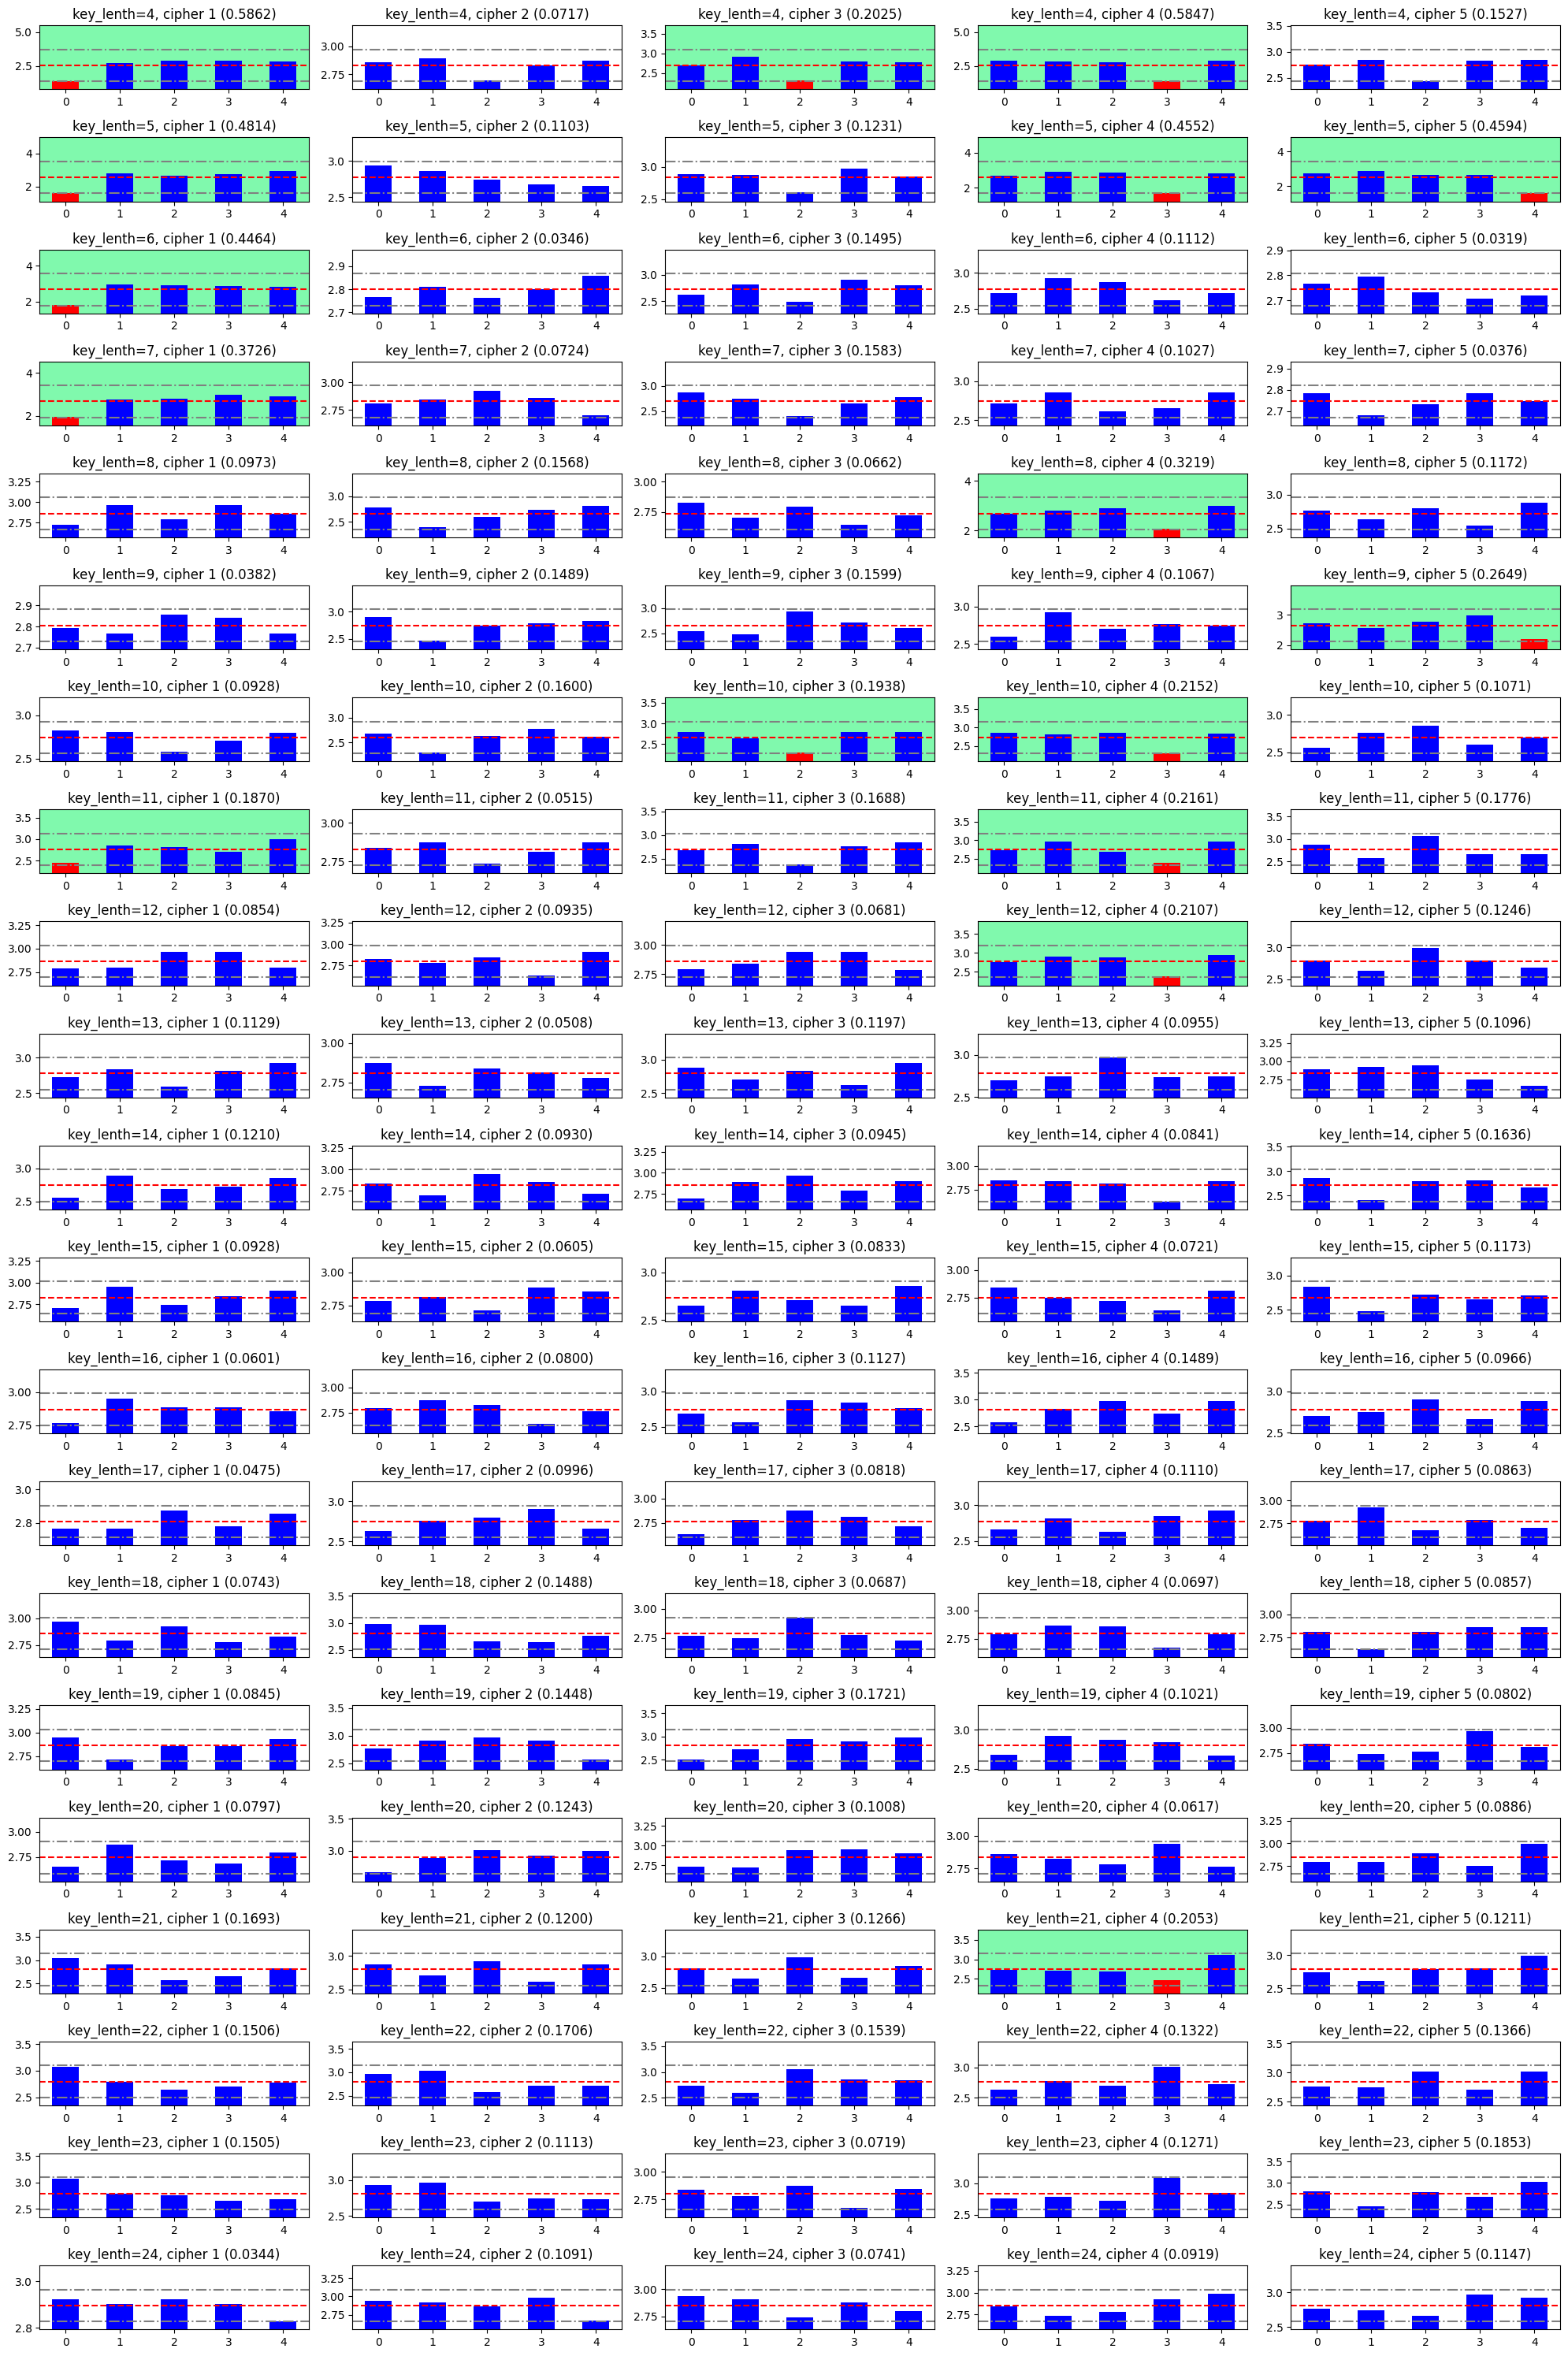

In [6]:
# The threshold value is picked empirically
start_entropy_analysis(30, 0.186)

total= 105
working= 11
correct= 11
wrong= 0
working rate= 10.476190476190476
true positive rate= 100.0
false positive rate= 0.0
0.05902752582730575 0.02242716427374797


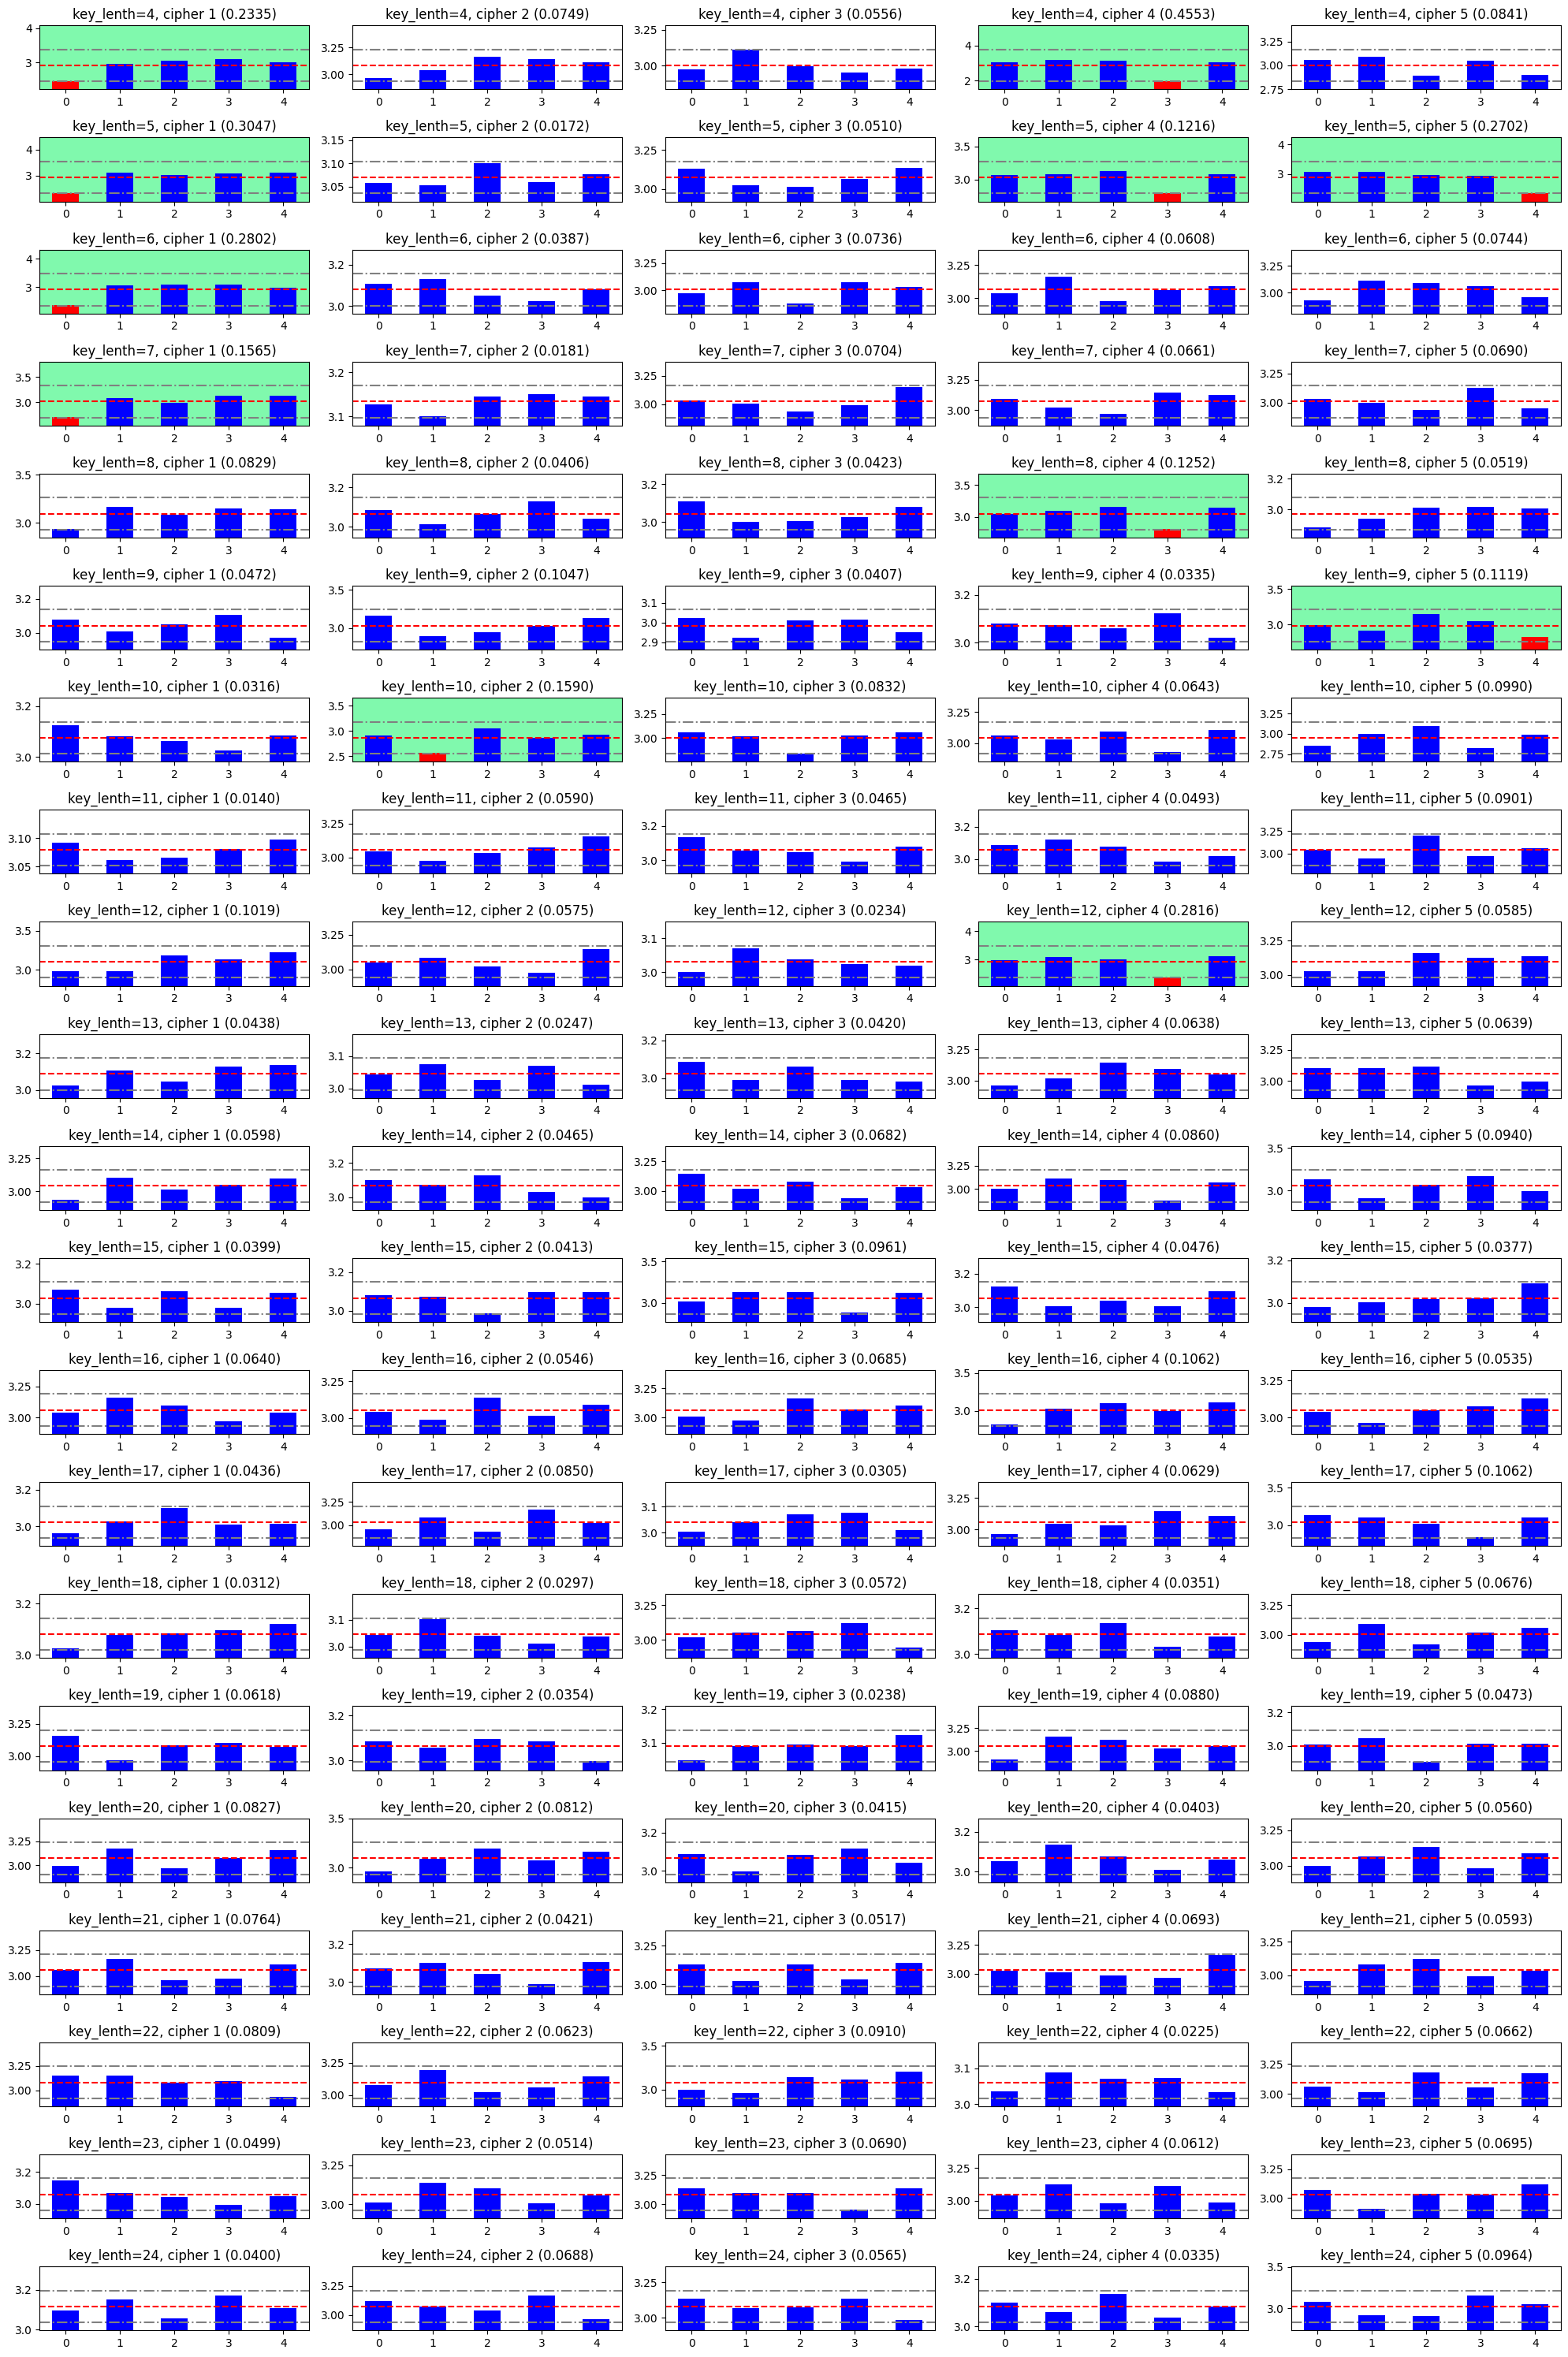

In [223]:
start_entropy_analysis(60, 0.11)

In [286]:
def cipher_removed_at(ciphertext, i):
    return ciphertext[:i] + ciphertext[i+1:]

def print_list(list):
    for i in list:
        print('%02d' % i, end=' ')
    print()

# Optimize the input ciphertext to match the plaintext,
# using entropy change within the searchspace
# Return the range of the ciphertext that could be removed to reduce the entropy
def select_first_local_minimum_removal(ciphertext, plaintext, search_space=30) -> range:

    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)
    start_ent = entropy(diffs)

    prev_ent = start_ent

    first_new_ciphertext = ciphertext[1:][:search_space]
    first_new_cipher_stream = encode(first_new_ciphertext)
    diffs = stream_diff(first_new_cipher_stream, plain_stream)
    first_ent = entropy(diffs)

    allow_increasing = first_ent > start_ent * 1.02

    ci = 0
    ents = []
    de_list = [] # delta(entropy)
    while ci < search_space:
        new_ciphertext = cipher_removed_at(ciphertext, ci)
        new_cipher_stream = encode(new_ciphertext[:search_space])
        plain_stream = encode(plaintext[:search_space])
        diffs = stream_diff(new_cipher_stream, plain_stream)
        ent = entropy(diffs)
        ents.append(ent)

        de = (ent - prev_ent) / prev_ent * 100
        de_list.append(de)

        if de > 1.2 and not allow_increasing:
            return range(max(0, ci-4), min(search_space, ci + 1))
        if de < 0:
            allow_increasing = False

        ci += 1
        prev_ent = ent
    
    return range(0)


In [274]:
def plot_diffs_fft(diffs, ax=None):
    freqs = np.fft.fft(diffs)
    mags = np.abs(freqs)
    # Plot only positive frequencies
    mags = mags[:len(mags)//2]
    zeros = np.where(mags == 0)[0]

    if ax:
        ax.stem(mags)  
        ax.set_title(f'{len(zeros)}\n{diffs}')

        if len(zeros) >= 1:
            ax.set_facecolor('xkcd:seafoam')
        # ax.set_xlabel('Frequency')
        # ax.set_ylabel('Magnitude')
        # ax.set_title('FFT of Data')
        

def search_fft_fit(ciphertext, plaintext, removal_candids, search_space=30, axes=None):
    # print('candidates', list(removal_candids))
    plot = axes is not None and len(axes) > 0
    for ss in range(8, search_space):
        if plot:
            ax_row = axes[ss-8]
        for i, ci in enumerate(removal_candids):
            if plot:
                if hasattr(ax_row, '__getitem__'):
                    ax = ax_row[i]
                else:
                    ax = ax_row
            new_ciphertext = cipher_removed_at(ciphertext, ci)
            cipher_stream = encode(new_ciphertext[:ss])
            plain_stream = encode(plaintext[:ss])
            diffs = stream_diff(cipher_stream, plain_stream)
            if plot:
                plot_diffs_fft(diffs, ax=ax)

            freqs = np.fft.fft(diffs)
            mags = np.abs(freqs)
            mags = mags[:len(mags)//2]
            zeros = np.where(mags == 0)[0]

            if len(zeros) >= 1:
                # print(len(zeros), diffs)
                return ss, ci
    
    return -1, None

In [10]:
fail_cases = {
    4: [1, 4],
    5: [1, 2],
    6: [1, 2, 3, 4],
    7: [1, 2, 3, 4],
    8: [0,1,2,4],
    9: [0,1,2,3],
    10: [0,1,4],
    11: [1,2,4],
    12: [0,1,2,4],
}

for key, failure in fail_cases.items():
    for fi in failure:
        candids = select_first_local_minimum_removal(ciphers[key][fi], plains[fi])
        l, remove_i = search_fft_fit(ciphers[key][fi], plains[fi], candids)
        print(f'key={key}, cipher={fi+1}, {(l, remove_i)}')

candidates [4, 5, 6, 7]
2 [2 3 4 1 2 3 4 1]
key=4, cipher=2, (8, 4)
candidates [0, 1]
2 [2 3 4 1 2 3 4 1]
key=4, cipher=5, (8, 0)
candidates [2, 3, 4, 5]
2 [3 4 5 1 2 3 4 5 1 2]
key=5, cipher=2, (10, 5)
candidates [7, 8, 9, 10]
2 [3 4 5 1 2 3 4 5 1 2]
key=5, cipher=3, (10, 9)
candidates [0, 1]
3 [1 2 3 4 5 0 1 2 3 4 5 0]
key=6, cipher=2, (12, 1)
candidates [15, 16, 17, 18]
3 [1 2 3 4 5 0 1 2 3 4 5 0]
key=6, cipher=3, (12, 15)
candidates [5, 6, 7, 8]
3 [1 2 3 4 5 0 1 2 3 4 5 0]
key=6, cipher=4, (12, 7)
candidates [9, 10, 11, 12]
3 [1 2 3 4 5 0 1 2 3 4 5 0]
key=6, cipher=5, (12, 12)
candidates [0, 1, 2]
key=7, cipher=2, (-1, None)
candidates [21, 22, 23, 24]
3 [1 2 3 4 5 6 0 1 2 3 4 5 6 0]
key=7, cipher=3, (14, 21)
candidates [11, 12, 13, 14]
3 [1 2 3 4 5 6 0 1 2 3 4 5 6 0]
key=7, cipher=4, (14, 14)
candidates [9, 10, 11, 12]
key=7, cipher=5, (-1, None)
candidates [0, 1, 2]
key=8, cipher=1, (-1, None)
candidates [15, 16, 17, 18]
4 [1 2 3 4 5 6 7 0 1 2 3 4 5 6 7 0]
key=8, cipher=2, (16, 1

In [287]:
def start_entropy_anomaly(ciphertext, N=30, threshold=0.186, ax=None, pick_min=False):
    cipher_stream = encode(ciphertext[:N])

    ents = []

    for pi, plaintext in enumerate(plains):
        plain_stream = encode(plaintext[:N])
        diffs = stream_diff(cipher_stream, plain_stream)
        ent = entropy(diffs)
        ents.append(ent)
    
    if ax:
        ax.bar(range(1, 6), ents, width=0.5)
        ent_avg = np.mean(ents)
        ent_std = np.std(ents)

        ax.set_title(f'std={ent_std:.4f}')
        ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
        ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
        ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
    
    if pick_min:
        return np.argmin(ents)
    
    if np.std(ents) > threshold:
        return np.argmin(ents)

    return -1


def try_remove_one_random_char(ciphertext):
    for pi, plaintext in enumerate(plains):
        candids = select_first_local_minimum_removal(ciphertext, plaintext)
        l, remove_i = search_fft_fit(ciphertext, plaintext, candids)

        # optimization success
        if l != -1:
            return pi
    
    return -1


def decrypt_1(ciphertext, N=30, threshold=0.186):
    """
    # Strategy used:
    1. Start Point Entropy Analysis -> Look for anomaly using std
    2. If no anomaly found,
        try to remove a single character and look for anomaly again
        using entropy change and FFT
    """

    anomaly = start_entropy_anomaly(ciphertext, N, threshold)

    if anomaly >= 0:
        return (anomaly, 'start anomaly')

    optimization_success_pi = try_remove_one_random_char(ciphertext)

    if optimization_success_pi >= 0:
        return (optimization_success_pi, 'optim')
    
    return (start_entropy_anomaly(ciphertext, N=60, threshold=0.11, pick_min=True), 'last guess: minimum entropy')

total= 105
accuracy= 92.6829268292683
correct= 51
wrong= 54
guess= 64
correct rate= 48.57142857142857
wrong rate= 51.42857142857142
guess rate= 60.952380952380956


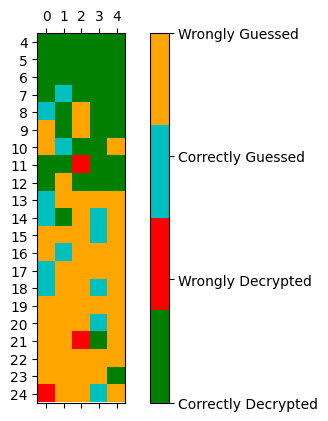

In [288]:
results = np.zeros((21, 5))

for key, cipher_of_key in ciphers.items():
    for ci, cipher in enumerate(cipher_of_key):
        guess, reason = decrypt_1(cipher)
        # correct
        if guess == ci:
            if reason.startswith('last guess'):
                results[key-4, ci] = 2
            else:
                results[key-4, ci] = 0
        # wrong
        else:
            if reason.startswith('last guess'):
                results[key-4, ci] = 3
            else:
                results[key-4, ci] = 1

total_cases = 21 * 5
correct_cases = np.sum(results == 0) + np.sum(results == 2)
wrong_cases = np.sum(results == 1) + np.sum(results == 3)
guess_cases = np.sum(results == 2) + np.sum(results == 3)
decrypt_cases = total_cases - guess_cases
accuracy = np.sum(results == 0) / decrypt_cases * 100

print('total=', total_cases)
print('accuracy=', accuracy)
print('correct=', correct_cases)
print('wrong=', wrong_cases)
print('guess=', guess_cases)
print('correct rate=', correct_cases / total_cases * 100)
print('wrong rate=', wrong_cases / total_cases * 100)
print('guess rate=', guess_cases / total_cases * 100)

colors = ['green', 'red', 'c', 'orange']
labels = ['Correctly Decrypted', 'Wrongly Decrypted', 'Correctly Guessed', 'Wrongly Guessed']
cmap = ListedColormap(colors)

fig, ax = plt.subplots()
cax = ax.matshow(results, cmap=cmap)

ax.set_yticks(range(21))
ax.set_yticklabels(np.arange(4, results.shape[0] + 4))

cbar = plt.colorbar(cax, ticks=np.arange(0, 4))
cbar.ax.set_yticklabels(labels)

plt.show()

In [261]:
def failure_analysis(keylen, correct):
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))

    ciphertext = ciphers[keylen][correct]
    anom = start_entropy_anomaly(ciphertext, ax=axes[0])
    if anom >= 0:
        print("start anomaly worked out!")
        return
    print("start anomaly didn't work!:", anom)
    plain_stream = encode(plains[correct][:30])

    for pi, plaintext in enumerate(plains):
        candids = select_first_local_minimum_removal(ciphertext, plaintext)
        l, remove_i = search_fft_fit(ciphertext, plaintext, candids)
        print(f'{pi}: candids {candids} -> {(l, remove_i)}', list(candids))

        # optimization succeded
        if l != -1:
            new_cipher = cipher_removed_at(ciphertext, remove_i)
            diffs = stream_diff(encode(new_cipher[:30]), plain_stream)
            print('ent', entropy(diffs))

            argmin = start_entropy_anomaly(new_cipher, N=30, pick_min=True)
            print(argmin)
            break
    
    print("optimizing ciphertext didn't work out!")
    print("probably the ciphertext has no random character at the head part, or")
    print("more than one random character at the head part")

    print_list(range(30))
    print_list(encode(ciphertext[:30]))
    print_list(plain_stream)
    print_list(stream_diff(encode(ciphertext[:30]), plain_stream))

start anomaly didn't work!: -1
0: candids range(0, 2) -> (-1, None) [0, 1]
1: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
2: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
3: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
4: candids range(0, 5) -> (-1, None) [0, 1, 2, 3, 4]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
08 21 03 20 08 18 08 14 12 04 01 25 12 07 16 11 25 23 16 20 14 04 20 24 16 05 15 22 04 24 
20 18 05 14 03 08 05 04 00 23 09 03 11 05 18 23 15 18 11 00 15 18 09 05 14 20 01 20 09 15 
15 03 25 06 05 10 03 10 12 08 19 22 01 02 25 15 10 05 05 20 26 13 11 19 02 12 14 02 22 09 


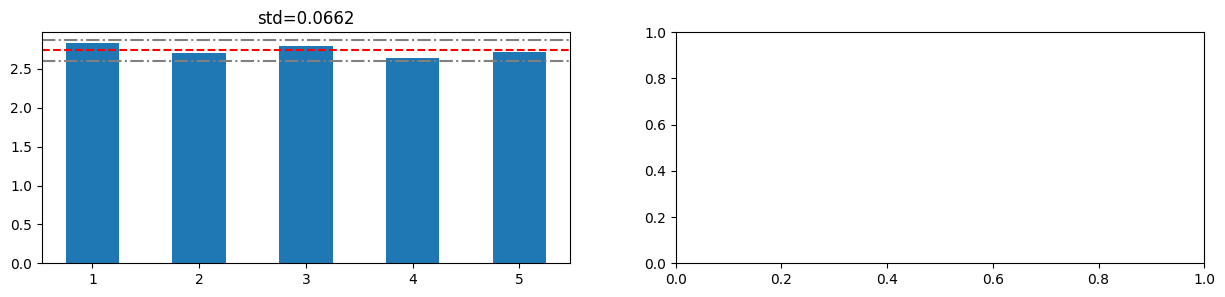

In [262]:
# two random characters at the head part at index 0 and 2
failure_analysis(8, 2)

start anomaly didn't work!: -1
0: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
1: candids range(0, 3) -> (-1, None) [0, 1, 2]
2: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
3: candids range(7, 12) -> (-1, None) [7, 8, 9, 10, 11]
4: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
03 03 21 17 14 13 11 26 09 01 00 09 03 22 24 10 25 07 02 21 00 16 02 06 08 23 05 12 12 03 
02 01 18 13 09 05 19 20 00 08 01 19 20 05 19 00 19 16 01 04 05 19 00 06 05 22 05 18 19 00 
01 02 03 04 05 08 19 06 09 20 26 17 10 17 05 10 06 18 01 17 22 24 02 00 03 01 00 21 20 03 
0 9 11 12 21 22 24 


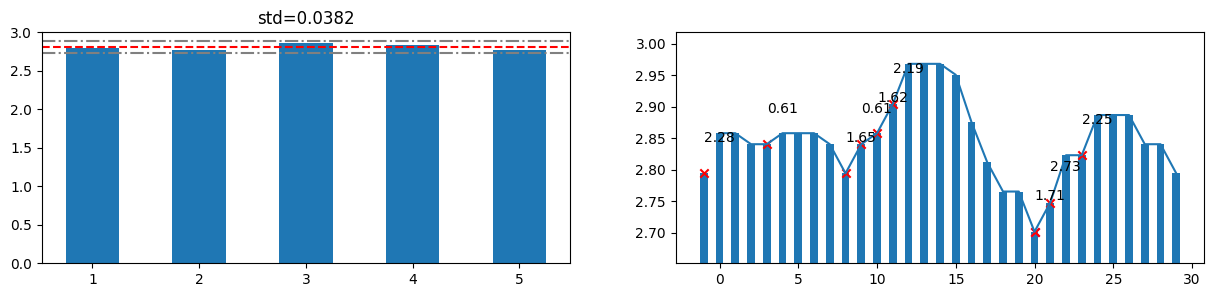

In [269]:
# two random characters at the head part at index 5 and ?
failure_analysis(9, 0)
plot_optimizer_behavior(ciphers[9][0], plains[0], 30)

start anomaly didn't work!: -1
0: candids range(10, 15) -> (-1, None) [10, 11, 12, 13, 14]
1: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
2: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
3: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
4: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
21 20 08 18 08 14 12 12 05 00 24 11 06 15 10 05 24 03 23 18 12 02 18 19 22 14 00 11 21 01 
20 18 05 14 03 08 05 04 00 23 09 03 11 05 18 23 15 18 11 00 15 18 09 05 14 20 01 20 09 15 
01 02 03 04 05 06 07 08 05 04 15 08 22 10 19 09 09 12 12 18 24 11 09 14 08 21 26 18 12 13 
6 8 13 16 26 


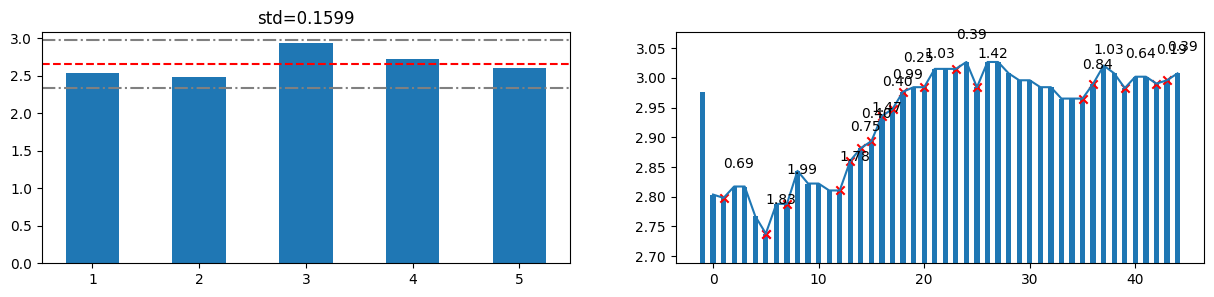

In [291]:
# optimization failed to find the random character correctly (correct=08)
failure_analysis(9, 2)
plot_optimizer_behavior(ciphers[9][2], plains[2], 45)

start anomaly didn't work!: -1
0: candids range(8, 13) -> (-1, None) [8, 9, 10, 11, 12]
1: candids range(0, 1) -> (-1, None) [0]
2: candids range(0, 1) -> (-1, None) [0]
3: candids range(0, 2) -> (-1, None) [0, 1]
4: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
09 04 04 22 18 15 12 00 02 10 09 03 22 24 10 25 07 00 25 11 17 05 06 07 22 12 04 11 11 02 
02 01 18 13 09 05 19 20 00 08 01 19 20 05 19 00 19 16 01 04 05 19 00 06 05 22 05 18 19 00 
07 03 13 09 09 10 20 07 02 02 08 11 02 19 18 25 15 11 24 07 12 13 06 01 17 17 26 20 19 02 
12 15 16 17 19 23 25 27 


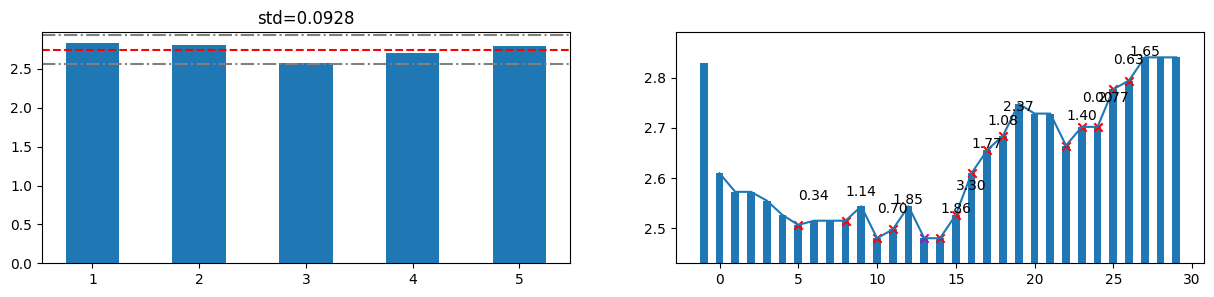

In [292]:
# optimizer failed to guess the random character correctly
failure_analysis(10, 0)
plot_optimizer_behavior(ciphers[10][0], plains[0], 30)

start anomaly didn't work!: -1
0: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
1: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
2: candids range(0, 0) -> (-1, None) []
3: candids range(5, 10) -> (-1, None) [5, 6, 7, 8, 9]
4: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
06 08 18 26 20 10 17 10 03 10 17 17 04 08 14 25 23 23 11 25 00 03 13 18 22 12 26 18 22 14 
04 05 14 21 14 03 09 01 20 09 15 14 00 03 08 18 15 14 01 24 25 00 09 13 16 05 18 09 12 13 
02 03 04 05 06 07 08 09 10 01 02 03 04 05 06 07 08 09 10 01 02 03 04 05 06 07 08 09 10 01 


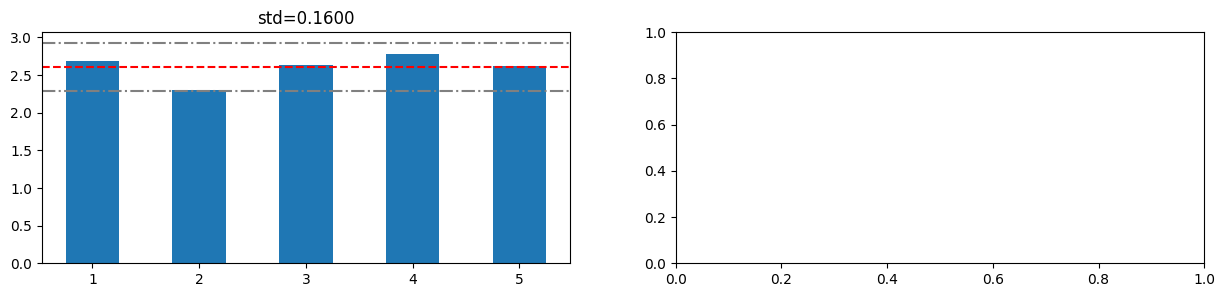

In [293]:
# no random character at the head part
# the start entropy test failed due to the long key length
failure_analysis(10, 1)

start anomaly didn't work!: -1
0: candids range(4, 9) -> (-1, None) [4, 5, 6, 7, 8]
1: candids range(0, 3) -> (-1, None) [0, 1, 2]
2: candids range(0, 2) -> (-1, None) [0, 1]
3: candids range(0, 4) -> (-1, None) [0, 1, 2, 3]
4: candids range(0, 3) -> (-1, None) [0, 1, 2]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
21 06 12 18 11 12 26 18 24 08 02 12 18 24 10 26 16 01 03 03 16 20 24 03 12 06 15 25 20 24 
19 03 08 13 05 05 18 09 14 07 00 09 14 19 20 09 20 21 20 15 18 00 08 01 09 18 12 15 03 11 
02 03 04 05 06 07 08 09 10 01 02 03 04 05 17 17 23 07 10 15 25 20 16 02 03 15 03 10 17 13 
0 2 3 15 17 20 21 22 


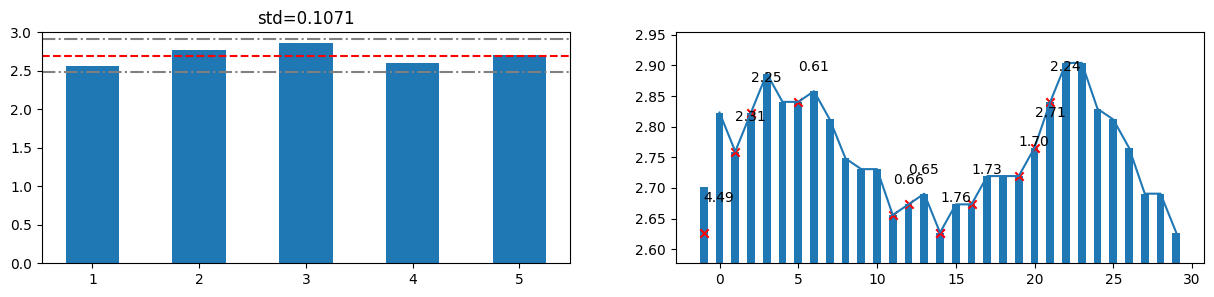

In [264]:
# optimizer failed to guess the random character correctly (correct=14)
failure_analysis(10, 4)
plot_optimizer_behavior(ciphers[10][4], plains[4], 30)

start anomaly didn't work!: -1
0: candids range(2, 7) -> (-1, None) [2, 3, 4, 5, 6]
1: candids range(0, 2) -> (-1, None) [0, 1]
2: candids range(3, 8) -> (-1, None) [3, 4, 5, 6, 7]
3: candids range(0, 3) -> (-1, None) [0, 1, 2]
4: candids range(1, 6) -> (-1, None) [1, 2, 3, 4, 5]
optimizing ciphertext didn't work out!
probably the ciphertext has no random character at the head part, or
more than one random character at the head part
00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
06 13 00 18 21 15 22 10 05 05 26 14 26 18 02 16 11 21 15 22 06 02 01 04 23 05 20 17 18 13 
04 05 14 21 14 03 09 01 20 09 15 14 00 03 08 18 15 14 01 24 25 00 09 13 16 05 18 09 12 13 
02 08 13 24 07 12 13 09 12 23 11 00 26 15 21 25 23 07 14 25 08 02 19 18 07 00 02 08 06 00 
1 3 5 11 12 19 


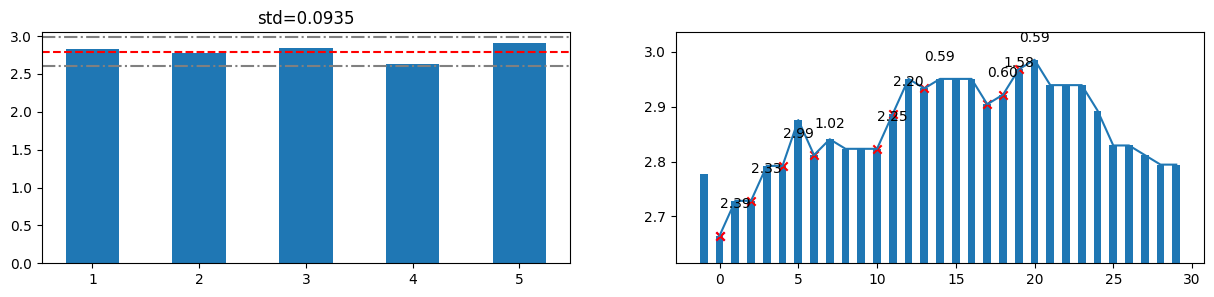

In [266]:
failure_analysis(12, 1)
plot_optimizer_behavior(ciphers[12][1], plains[1], 30)

In [ ]:
# We know removing a character is not enough...

removal_candids = select_first_local_minimum_removal(ciphers[7][1], plains[1])
print(removal_candids)

fig, axes = plt.subplots(22, len(removal_candids), figsize=(20, 30))
l, i =search_fft_fit(ciphers[7][1], plains[1], removal_candids, axes=axes)
fig.tight_layout()
print(l, i)

00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
20 05 11 17 10 11 18 10 16 10 04 14 20 18 19 21 11 23 25 25 21 18 01 10 04 13 08 23 18 20 
19 03 08 13 05 05 18 09 14 07 00 09 14 19 20 09 20 21 20 15 18 00 08 01 09 18 12 15 03 11 
01 02 03 04 05 06 00 01 02 03 04 05 06 26 26 12 18 02 05 10 03 18 20 09 22 22 23 08 15 09 
range(9, 14)
14 13


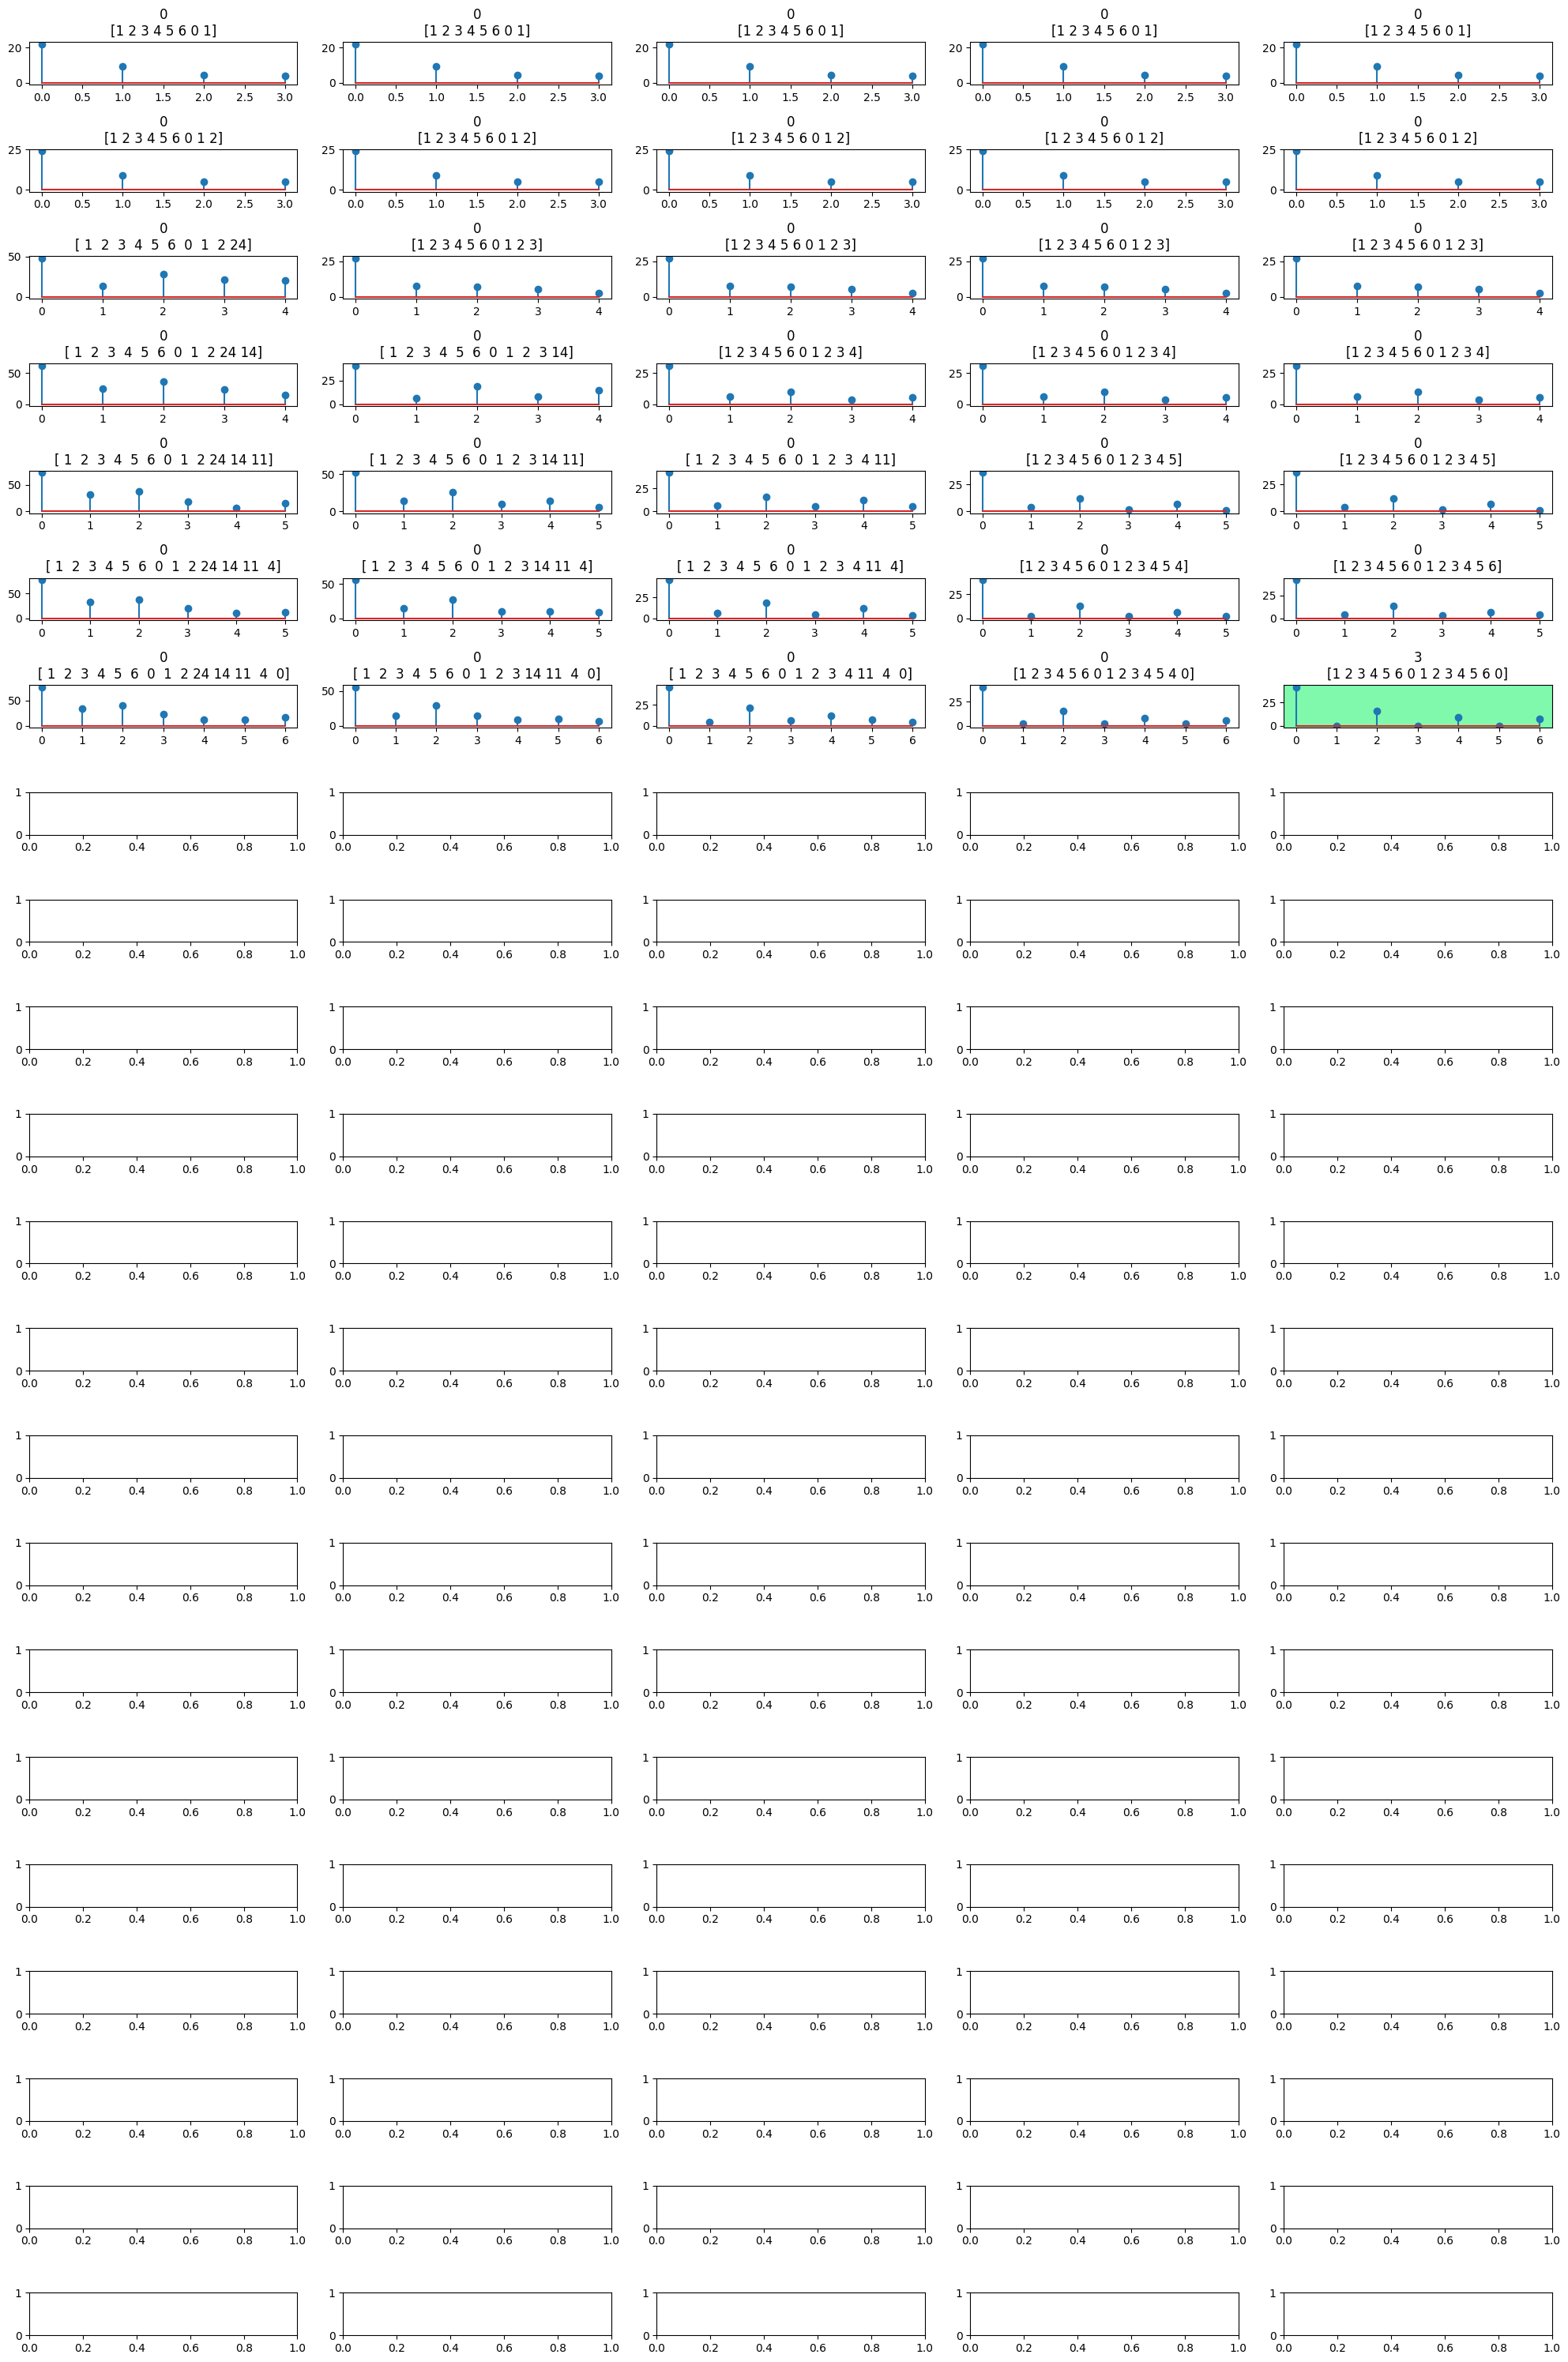

In [183]:
# We know removing a character is not enough...

# plot_optimizer_behavior(ciphers[9][0], plains[0], 30)

print_list(range(30))
print_list(encode(ciphers[7][4][:30]))
print_list(encode(plains[4][:30]))
print_list(stream_diff(encode(ciphers[7][4][:30]), encode(plains[4][:30])))

removal_candids = select_first_local_minimum_removal(ciphers[7][4], plains[4])
print(removal_candids)

fig, axes = plt.subplots(22, len(removal_candids), figsize=(20, 30))
l, i = search_fft_fit(ciphers[7][4], plains[4], removal_candids, axes=axes)
fig.tight_layout()
print(l, i)

In [185]:
def plot_optimizer_behavior(ciphertext, plaintext, search_space=30, correct=None):
    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)

    ents = []
    de_list = []
    start_ent = entropy(diffs)
    prev_ent = start_ent

    first_new_ciphertext = ciphertext[1:][:search_space]
    first_new_cipher_stream = encode(first_new_ciphertext)
    diffs = stream_diff(first_new_cipher_stream, plain_stream)
    first_ent = entropy(diffs)

    allow_increasing = first_ent > start_ent * 1.05

    ci = 0
    while ci < search_space:
        new_ciphertext = cipher_removed_at(ciphertext, ci)
        new_cipher_stream = encode(new_ciphertext[:search_space])
        diffs = stream_diff(new_cipher_stream, plain_stream)
        ent = entropy(diffs)

        ents.append(ent)
        de = (ent - prev_ent) / prev_ent * 100
        de_list.append(de)

        if de > 1.2 and not allow_increasing:
            print(ci, end=' ')
        if de < 0:
            allow_increasing = False

        ci += 1
        prev_ent = ent
    
    print()
    
    # plt.plot(range(search_space), de_list, c='red')
    plt.ylim(np.min(ents) - 0.05, np.max(ents) + 0.05)
    plt.bar(range(-1, search_space), [start_ent] + ents, width=0.5)
    plt.plot(range(search_space), ents)
    plt.axhline(0, linestyle='--', color='gray')

    min_ent_i = np.argmin(ents)
    if correct:
        plt.scatter(correct, ents[correct], marker='s', c='r')
    plt.scatter(min_ent_i, ents[min_ent_i], c='m', marker='x')

    for ci, de in enumerate(de_list):
        if de > 0:
            plt.scatter(ci - 1, ents[ci - 1], marker='x', c='red')
            plt.annotate(f'{de:.2f}', (ci - 1, ents[ci - 1] + 0.05))
    

8 16 18 19 24 25 26 29 


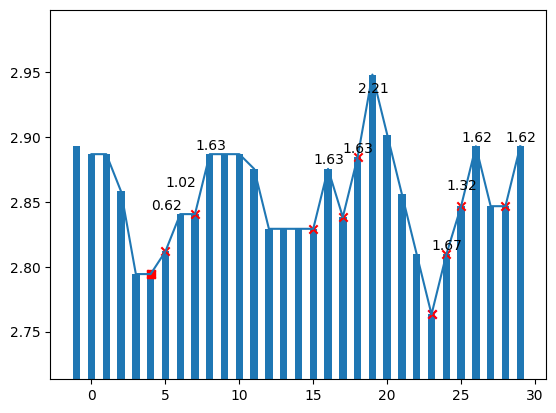

In [186]:
plot_optimizer_behavior(ciphers[4][1], plains[1], correct=4)

2 4 11 13 18 21 23 25 


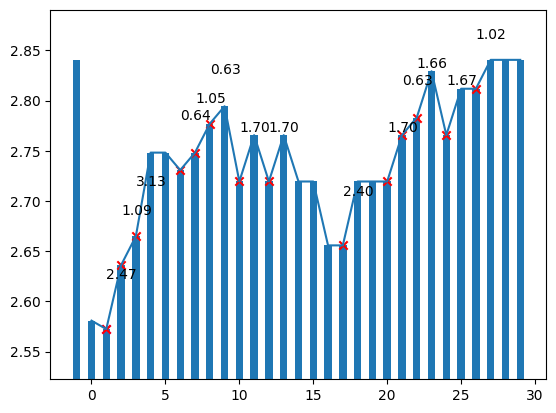

In [187]:
plot_optimizer_behavior(ciphers[4][4], plains[4], correct=0)

6
7
8
10
11
15
16
17
19
26
29


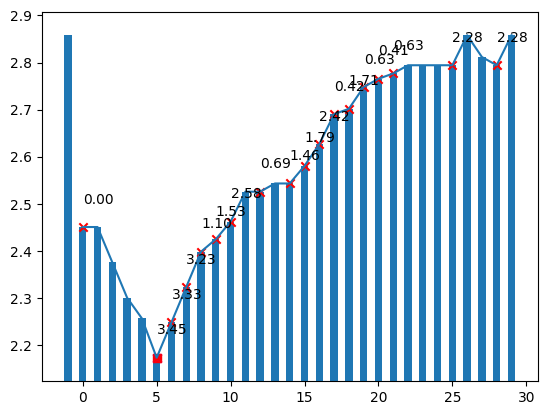

In [120]:
plot_optimizer_behavior(ciphers[5][1], plains[1], correct=5)

19
25
26


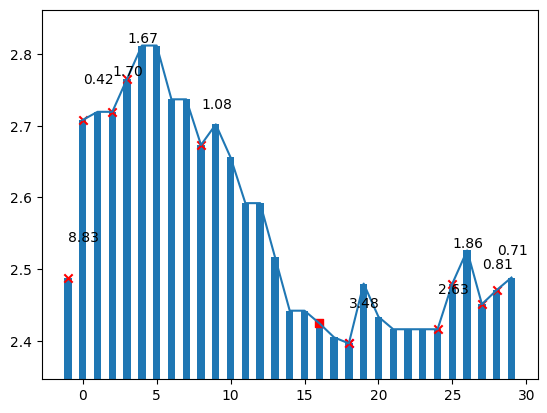

In [121]:
plot_optimizer_behavior(ciphers[6][2], plains[2], correct=16)

25
26
27
28
29


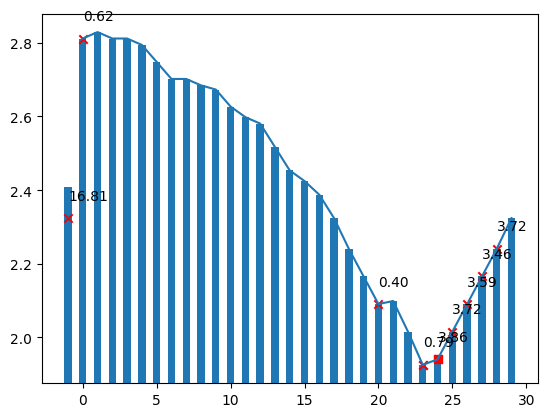

In [122]:
plot_optimizer_behavior(ciphers[7][2], plains[2], correct=24)

In [113]:
def autocorr_analysis(ciphertext, plaintext, search_space=30, debug=False):
    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = np.array([diff(i_c, i_p) for i_c, i_p in zip(cipher_stream, plain_stream)])

    if debug:
        print(diffs)

    autocorr = np.correlate(diffs, diffs, mode='full')

    plt.plot(autocorr)
    return autocorr[autocorr.size // 2:]

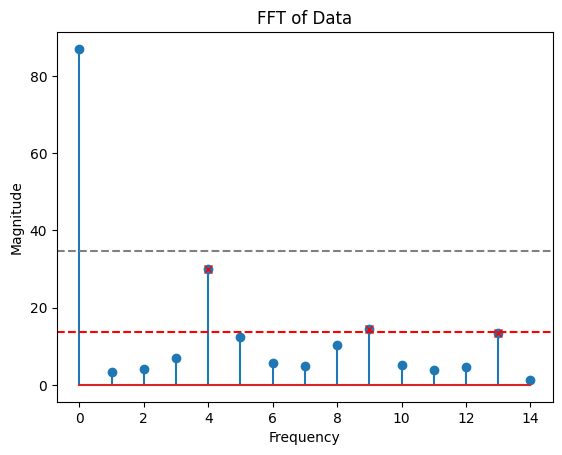

[1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2 3 4 5 6 0 1 2]
[87.          3.23171414  4.11752773  6.84715407 30.08862324 12.28820573
  5.66481862  4.96533337 10.4571556  14.49539517  5.19615242  3.96627516
  4.57272676 13.34803917  1.1698777 ]
FFT values:
Frequency 0: (87+0j)
Frequency 1: (-3.163118960624632-0.6623101383157985j)
Frequency 2: (-3.8002795251225168-1.5849006811577535j)
Frequency 3: (-5.836881039375367-3.5797120768908206j)
Frequency 4: (-23.85718537089791-18.334665375317684j)
Frequency 5: (9.499999999999998+7.794228634059946j)
Frequency 6: (4.663118960624633+3.216440812888141j)
Frequency 7: (4.663118960624633+1.705830302404197j)
Frequency 8: (10.452755367621041-0.30332905030084234j)
Frequency 9: (-13.663118960624631+4.841039294052673j)
Frequency 10: (-4.5+2.598076211353315j)
Frequency 11: (-3.1631189606246304+2.392909745752296j)
Frequency 12: (-3.163118960624633+3.302197525465046j)
Frequency 13: (4.663118960624631-12.507016878887121j)
Frequency 14: (-0.7952904716006168-0

array([369, 282, 224, 196, 178, 185, 218, 278, 212, 168, 147, 129, 129,
       148, 187, 142, 112,  98,  80,  73,  78,  96,  72,  56,  49,  31,
        17,   8,   5,   2])

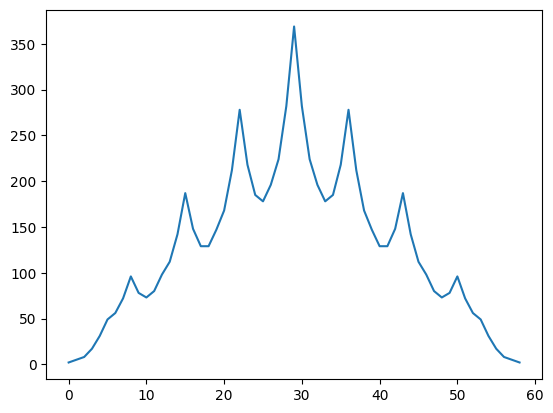

In [137]:
cipher = cipher_removed_at(ciphers[7][2], 24)
plain = plains[2]


fft_analysis(cipher, plain, search_space=30, debug=True)
autocorr_analysis(cipher, plain, debug=True, search_space=30)

In [106]:
def fft_analysis(ciphertext, plaintext, search_space=30, debug=False):
    cipher_stream = encode(ciphertext[:search_space])
    plain_stream = encode(plaintext[:search_space])
    diffs = stream_diff(cipher_stream, plain_stream)

    freqs = np.fft.fft(diffs)
    magnitudes = np.abs(freqs)
    magnitudes = magnitudes[:len(magnitudes)//2]
    peaks, _ = sp.signal.find_peaks(magnitudes)
    mag_mean = np.mean(magnitudes)
    mag_std = np.std(magnitudes)

    plt.stem(magnitudes)  # Plot only positive frequencies
    plt.plot(peaks, magnitudes[peaks], 'x', c='red')
    plt.xlabel('Frequency')
    plt.ylabel('Magnitude')
    plt.title('FFT of Data')
    plt.axhline(mag_mean, linestyle='--', color='red')
    plt.axhline(mag_mean + mag_std, linestyle='--', color='gray')
    plt.show()

    if debug:
        print(diffs)
        print(magnitudes)
        # Print the computed FFT values
        print("FFT values:")
        for i, value in enumerate(freqs):
            print(f"Frequency {i}: {value}")
        
        # Print magnitudes
        print(f"\nMagnitudes:")
        for i, mag in enumerate(magnitudes):
            print(f"Frequency {i}: {mag:.2f}")

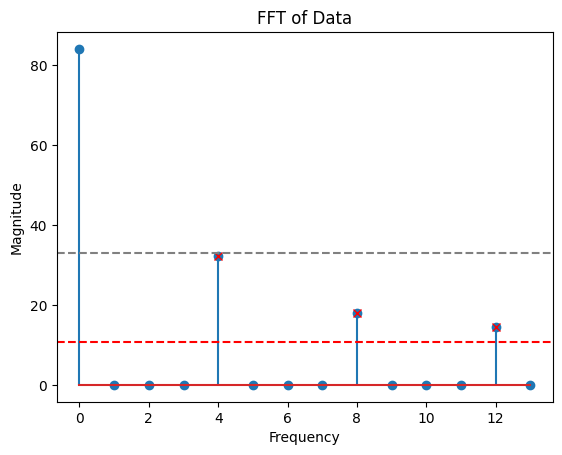

In [107]:
fft_analysis(ciphers[7][0], plains[0], search_space=28)

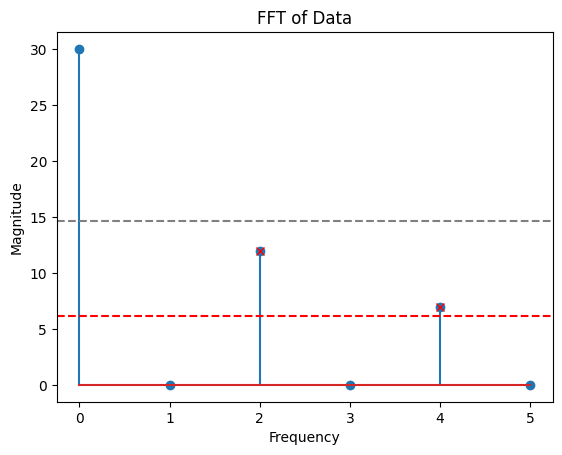

In [98]:
fft_analysis(ciphers[6][2], plains[2], search_space=12)

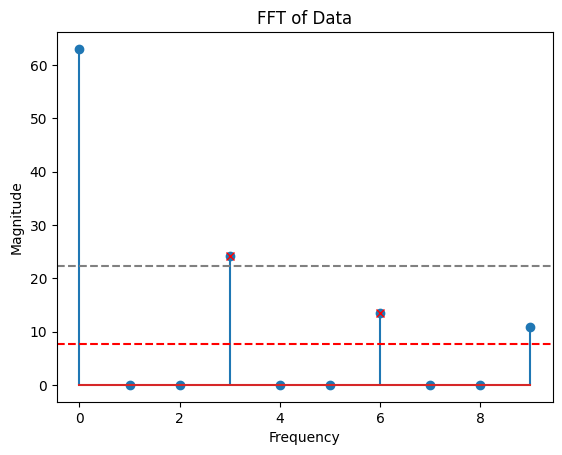

In [99]:
fft_analysis(ciphers[7][2], plains[2], search_space=21)

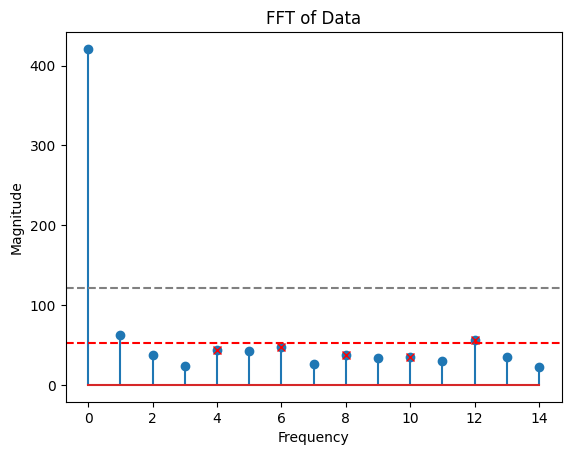

In [100]:
fft_analysis(ciphers[4][1], plains[1])

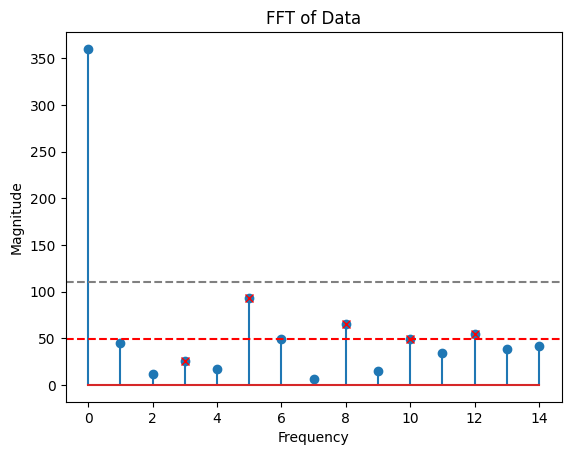

[ 1 18 25 26  9  2 17 13 23  9 10 22  0 18 23 13  4 16  2  9  6 16 12  2
  3 11 26  6 13  5]
[360.          45.18321762  11.9895269   25.57320402  17.43080863
  92.77391875  48.95787443   6.58841191  65.30324013  14.4572209
  49.56813493  33.70947307  54.38866179  37.97026599  41.72415349
  12.          41.72415349  37.97026599  54.38866179  33.70947307
  49.56813493  14.4572209   65.30324013   6.58841191  48.95787443
  92.77391875  17.43080863  25.57320402  11.9895269   45.18321762]
FFT values:
Frequency 0: (360+0j)
Frequency 1: (9.552969447091229-44.16179264183033j)
Frequency 2: (11.649230989488006+2.83622505729144j)
Frequency 3: (-13.28115294937453-21.854055461093466j)
Frequency 4: (-7.0508008655048435-15.941119682785036j)
Frequency 5: (-64.49999999999999-66.68395609140177j)
Frequency 6: (-33.45491502812526-35.74412020577223j)
Frequency 7: (-6.019335157631961-2.678577188846269j)
Frequency 8: (-8.301706831986538+64.77341147849425j)
Frequency 9: (-3.218847050625474-14.094334319273496j

In [101]:
fft_analysis(ciphers[4][4], plains[4], debug=True)

00 01 02 03 04 05 06 07 08 09 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
05 07 17 25 19 09 16 01 21 11 18 18 05 09 15 18 16 16 20 04 01 03 06 16 13 17 07 21 13 17 
04 05 14 21 14 03 09 01 20 09 15 14 00 03 08 18 15 14 01 24 25 00 09 13 16 05 18 09 12 13 
01 02 03 04 05 06 07 00 01 02 03 04 05 06 07 00 01 02 19 07 03 03 24 03 24 12 16 12 01 04 
2.3874857346534046
start_ent 2.3874857346534046
0  16.56732 2.7830282203847174 (18)
1  0.40699 2.794354822837744 (18)
2  0.00000 2.794354822837744 (18)
3 -2.68320 2.719376803555236 (17)
4 -0.64138 2.7019351987630844 (17)
5 -2.35577 2.638283781933603 (16)
6 -2.84192 2.5633057626510953 (15)
7 -1.80274 2.517095950613766 (14)
8 -1.83584 2.4708861385764362 (13)
9 -1.16429 2.4421179313312584 (13)
10 -0.71420 2.4246763265391067 (13)
11  0.00000 2.4246763265391067 (13)
12 -3.09229 2.349698307256599 (12)
13 -3.19096 2.2747202879740915 (11)
14 -3.66640 2.19131988405106 (10)
15 -2.90471 2.1276684672215787 (9)
16 -2.99160 2.0640170503920974

'egqysipaukrreiorpptdacfpmqgumqslnublrh yrffchljlyotvhhevyougfxtxhtfucgtstiuvhirku slgivfi os crfxjituxwehyienhvxfcebvkwiwivrclucshisuekqkeauycigfxtse t qgtsz cgdqcfvpukfsu wimndvcfhcdwoxzxhtjqdqdxivuukqpkmenlaeuwvttn uqvlevyedqqwhovutbzijlqkazbuinio tcghqky nhgugjxpzfucwf jeqcqdgomomfcvjmlnftdxjfjhjhvcvjapexcepjfmlatkqixygibscbiiflstgqxngslzblhqkgy egsisjhbmgchtwkkidlcepjfsodcoixfyeeggmhg eebfsahprebnzjzjuhnffcgttmutkqkqdgajtagvtvz ethklkolrarum osehgvdyktpugudfthesqeixfnljuwiskkt tcuxtxpambgmxzyutviyqtlstbyseuoslbtadzmoscarushzvrjpjdi wlfzhhevptbucxwgptptryxre vpomln eebfvcv ohtdtmky pxfawxkesaohxfslraglxmky ngomtxht'

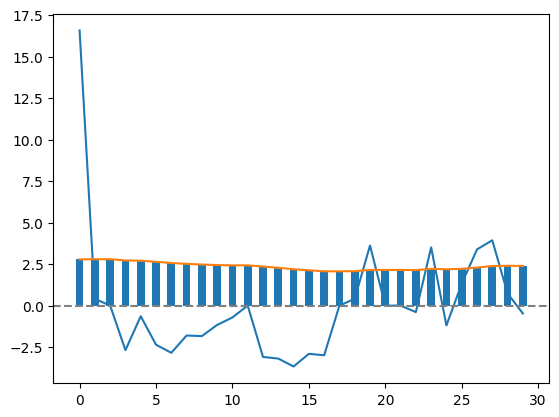

In [481]:
# start_ent < ent after 0-removed
cipher_stream = encode(ciphers[8][1][:30])
plain_stream = encode(plains[1][:30])
diffs = [diff(i_c, i_p) for i_c, i_p in zip(cipher_stream, plain_stream)]

print_list(range(30))
print_list(cipher_stream)
print_list(plain_stream)
print_list(diffs)
print(entropy(Counter(diffs)))

correct=18

fig,ax=plt.subplots()
select_first_local_minimum_removal(ciphers[8][1], plains[1], 1, ax=ax, debug=True)

In [251]:
# Allow optimzations to 2 chars (int(30 * PROB + 1))
def decrypt(cipher, search=30, threshold=0.034, ax = None):
    cipher_stream = encode(cipher[:search])
    ents =  []
    for plain in plains:
        plain_stream = encode(plain[:search])
        diffs = [diff( i_c, i_p ) for i_c, i_p in zip(cipher_stream, plain_stream)]
        counter = Counter(diffs)
        ent = entropy(counter)
        ents.append(ent)

    min_ent = min(ents)
    ent_avg = avg(ents)
    ent_std = std(ents)

    # Try to guess the plaintext from the anomaly
    for i, ent in enumerate(ents, 1):
        if ent == min_ent and ent_std > threshold:
            if ax:
                ax.bar(range(1, 6), ents)
                ax.bar(i, ent, color='red')
    
                ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
                ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
                ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
                ax.set_title(f'std={ent_std:.4f}')
            return i

    # Optimize the plaintext
    expected_randoms = int(30 * PROB + 1)
    stds = []
    ents_list = []
    for n in range(1, expected_randoms + 1):
        ents = []
        for plain in plains:
            new_cipher = select_first_local_minimum_removal(cipher, plain, n)
            plain_stream = encode(plain[:search])
            new_cipher_stream = encode(new_cipher[:search])
            diffs = [diff( i_c, i_p ) for i_c, i_p in zip(new_cipher_stream, plain_stream)]
            counter = Counter(diffs)
            ent = entropy(counter)
            ents.append(ent)

        ents_list.append(ents)
        min_ent = min(ents)
        ent_avg = avg(ents)
        ent_std = std(ents)
        stds.append(ent_std)

        for i, ent in enumerate(ents, 1):
            if ent == min_ent and ent_std > threshold:
                if ax:
                    ax.bar(range(1, 6), ents)
                    ax.bar(i, ent, color='red')
        
                    ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
                    ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
                    ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')

                    ax.set_title(f'std={ent_std:.4f}')
                return i

    max_std = max(stds)
    for i, s in enumerate(stds):
        if s == max_std and s > threshold:
            if ax:
                ents = ents_list[i]
                for i, ent in enumerate(ents, 1):
                    if ent == min_ent and ent_std > threshold:
                        if ax:
                            ax.bar(range(1, 6), ents)
                            ax.bar(i, ent, color='red')
                
                            ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
                            ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
                            ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
        
                            ax.set_title(f'std={ent_std:.4f}')
                        return i

    # Nothing interesting found, just plot the original data

    cipher_stream = encode(cipher[:search])
    ents =  []
    for plain in plains:
        plain_stream = encode(plain[:search])
        diffs = [diff( i_c, i_p ) for i_c, i_p in zip(cipher_stream, plain_stream)]
        counter = Counter(diffs)
        ent = entropy(counter)
        ents.append(ent)

    min_ent = min(ents)
    ent_avg = avg(ents)
    ent_std = std(ents)
    
    if ax:
        ax.bar(range(1, 6), ents)

        ax.axhline(ent_avg, color='r', linestyle='--', label='avg')
        ax.axhline(ent_avg - 2 * ent_std, color='gray', linestyle='-.', label='-2 std')
        ax.axhline(ent_avg + 2 * ent_std, color='gray', linestyle='-.', label='+2 std')
        ax.set_title(f'std={ent_std:.4f}')

decrypt1(ciphers[4][1])

2

true positive 27.61904761904762
false positive 2.857142857142857


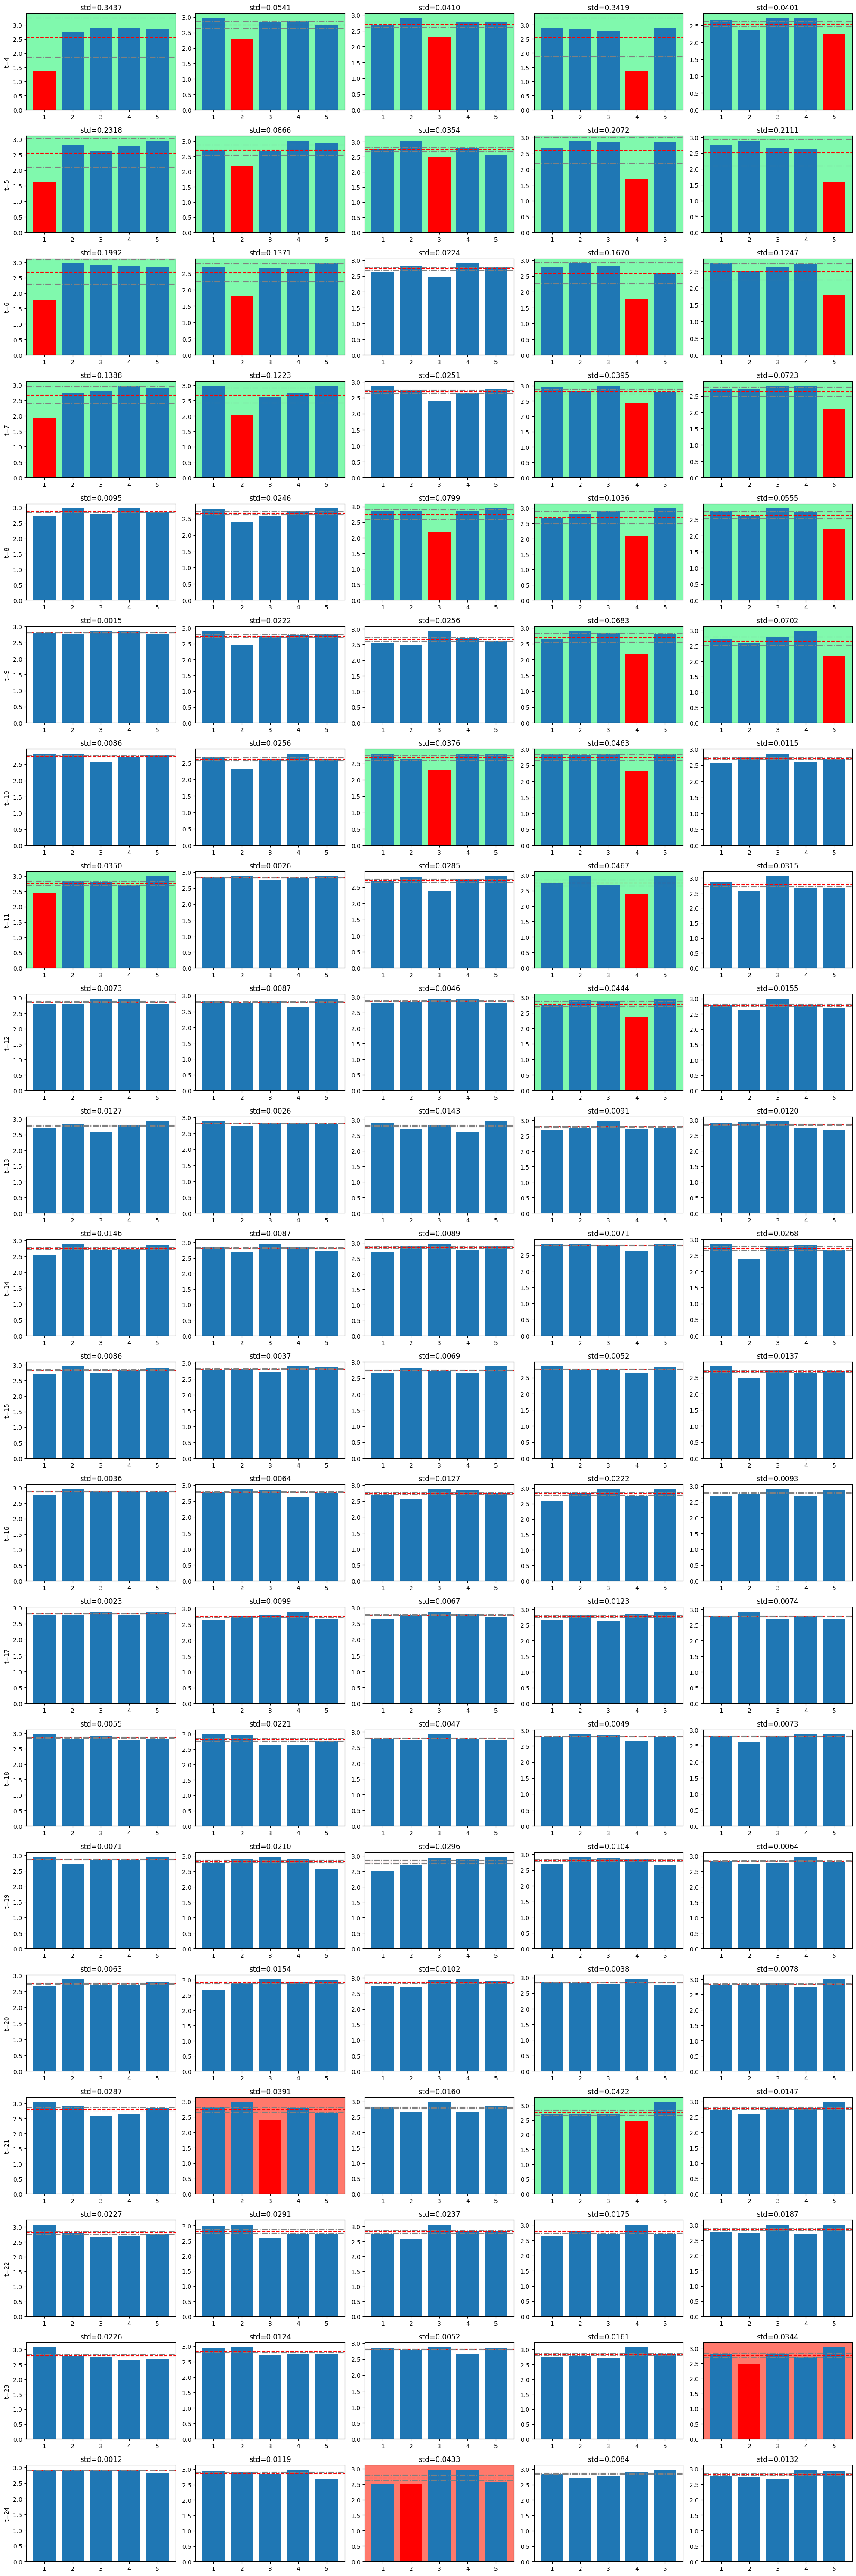

In [284]:
fig, axes = plt.subplots(len(keys), 5, figsize=(20, 60))

guessed_correctly = 0
guessed_wrongly = 0

for key in keys:
    k = key - 4
    ax_row = axes[key-4]
    ax_row[0].set_ylabel(f't={key}')
    for ci, ciphertext in enumerate(ciphers[key], 1):
        ax = ax_row[ci-1]
        guess = decrypt(ciphertext, search=30, threshold=0.034, ax=ax)
        if guess and guess == ci:
            guessed_correctly += 1
            ax.set_facecolor('xkcd:seafoam')
        if guess and guess != ci:
            guessed_wrongly += 1
            ax.set_facecolor('xkcd:salmon')

print('true positive', guessed_correctly / (len(keys) * 5) * 100)
print('false positive', guessed_wrongly / (len(keys) * 5) * 100)

plt.tight_layout()
plt.show()

true positive 25.71428571428571
false positive 6.666666666666667


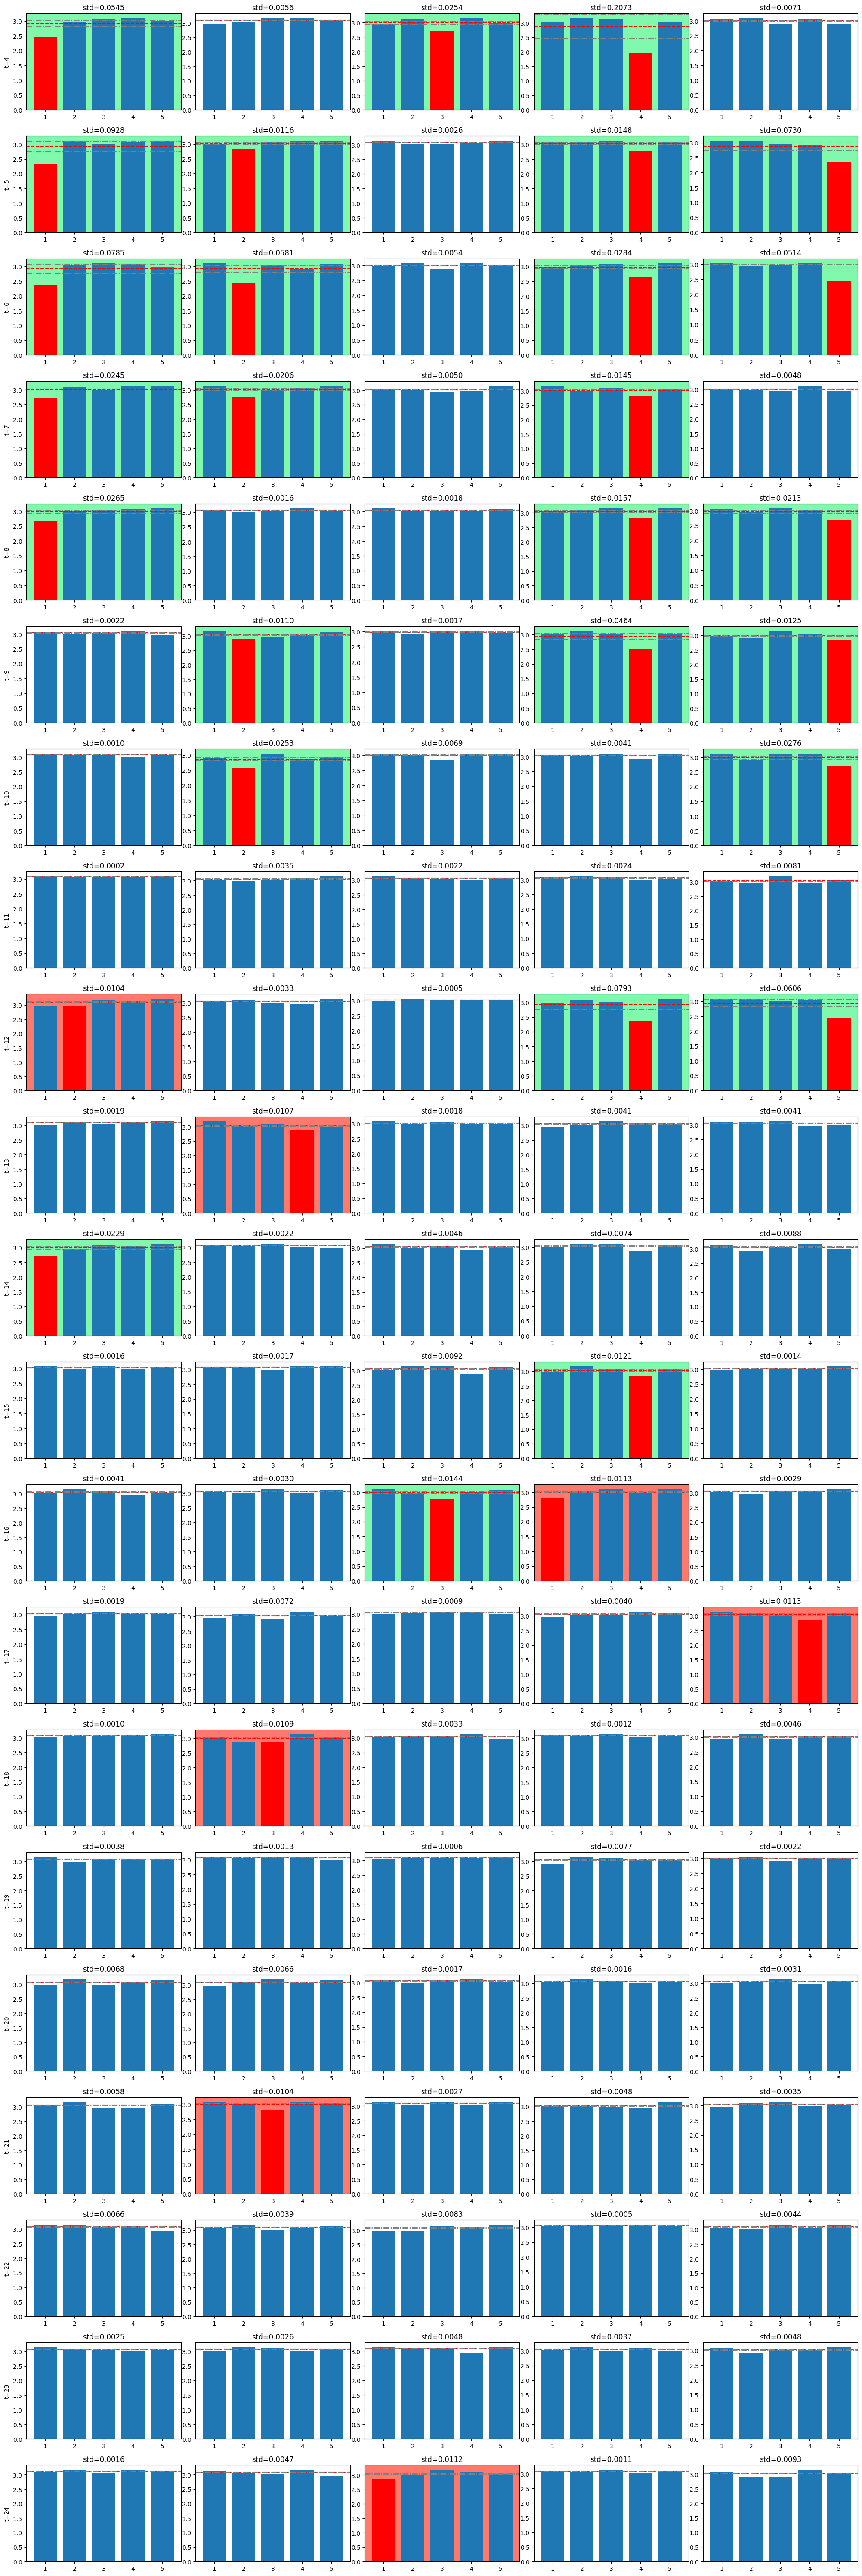

In [285]:
fig, axes = plt.subplots(len(keys), 5, figsize=(20, 60))

guessed_correctly = 0
guessed_wrongly = 0

for key in keys:
    k = key - 4
    ax_row = axes[key-4]
    ax_row[0].set_ylabel(f't={key}')
    for ci, ciphertext in enumerate(ciphers[key], 1):
        ax = ax_row[ci-1]
        guess = decrypt(ciphertext, search=60, threshold=0.01, ax=ax)
        if guess and guess == ci:
            guessed_correctly += 1
            ax.set_facecolor('xkcd:seafoam')
        if guess and guess != ci:
            guessed_wrongly += 1
            ax.set_facecolor('xkcd:salmon')

print('true positive', guessed_correctly / (len(keys) * 5) * 100)
print('false positive', guessed_wrongly / (len(keys) * 5) * 100)

plt.tight_layout()
plt.show()

true positive 27.61904761904762
false positive 2.857142857142857


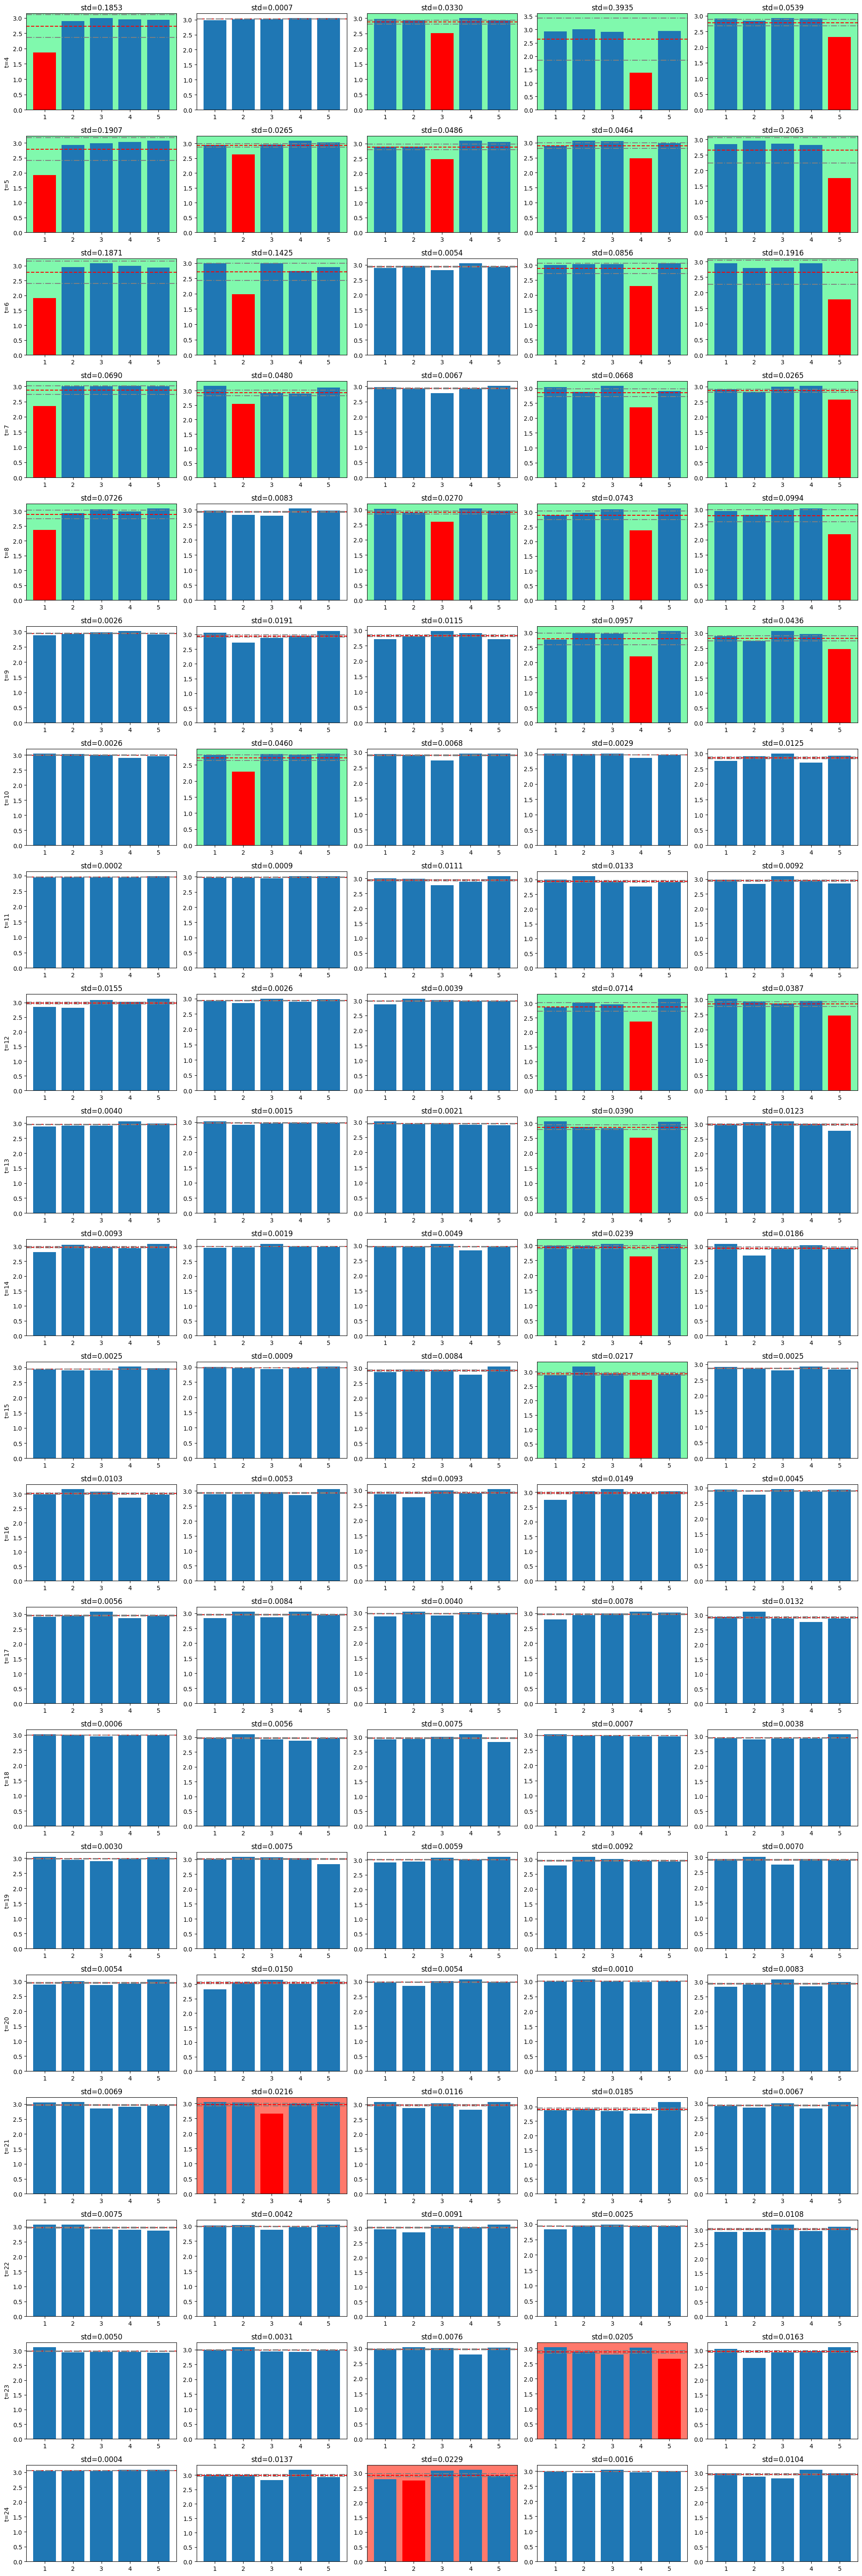

In [182]:
fig, axes = plt.subplots(len(keys), 5, figsize=(20, 60))

guessed_correctly = 0
guessed_wrongly = 0

for key in keys:
    k = key - 4
    ax_row = axes[key-4]
    ax_row[0].set_ylabel(f't={key}')
    for ci, ciphertext in enumerate(ciphers[key], 1):
        ax = ax_row[ci-1]
        guess = decrypt(ciphertext, search=45, threshold=0.02, ax=ax)
        if guess and guess == ci:
            guessed_correctly += 1
            ax.set_facecolor('xkcd:seafoam')
        if guess and guess != ci:
            guessed_wrongly += 1
            ax.set_facecolor('xkcd:salmon')

print('true positive', guessed_correctly / (len(keys) * 5) * 100)
print('false positive', guessed_wrongly / (len(keys) * 5) * 100)

plt.tight_layout()
plt.show()

true positive 31.428571428571427
false positive 32.38095238095238


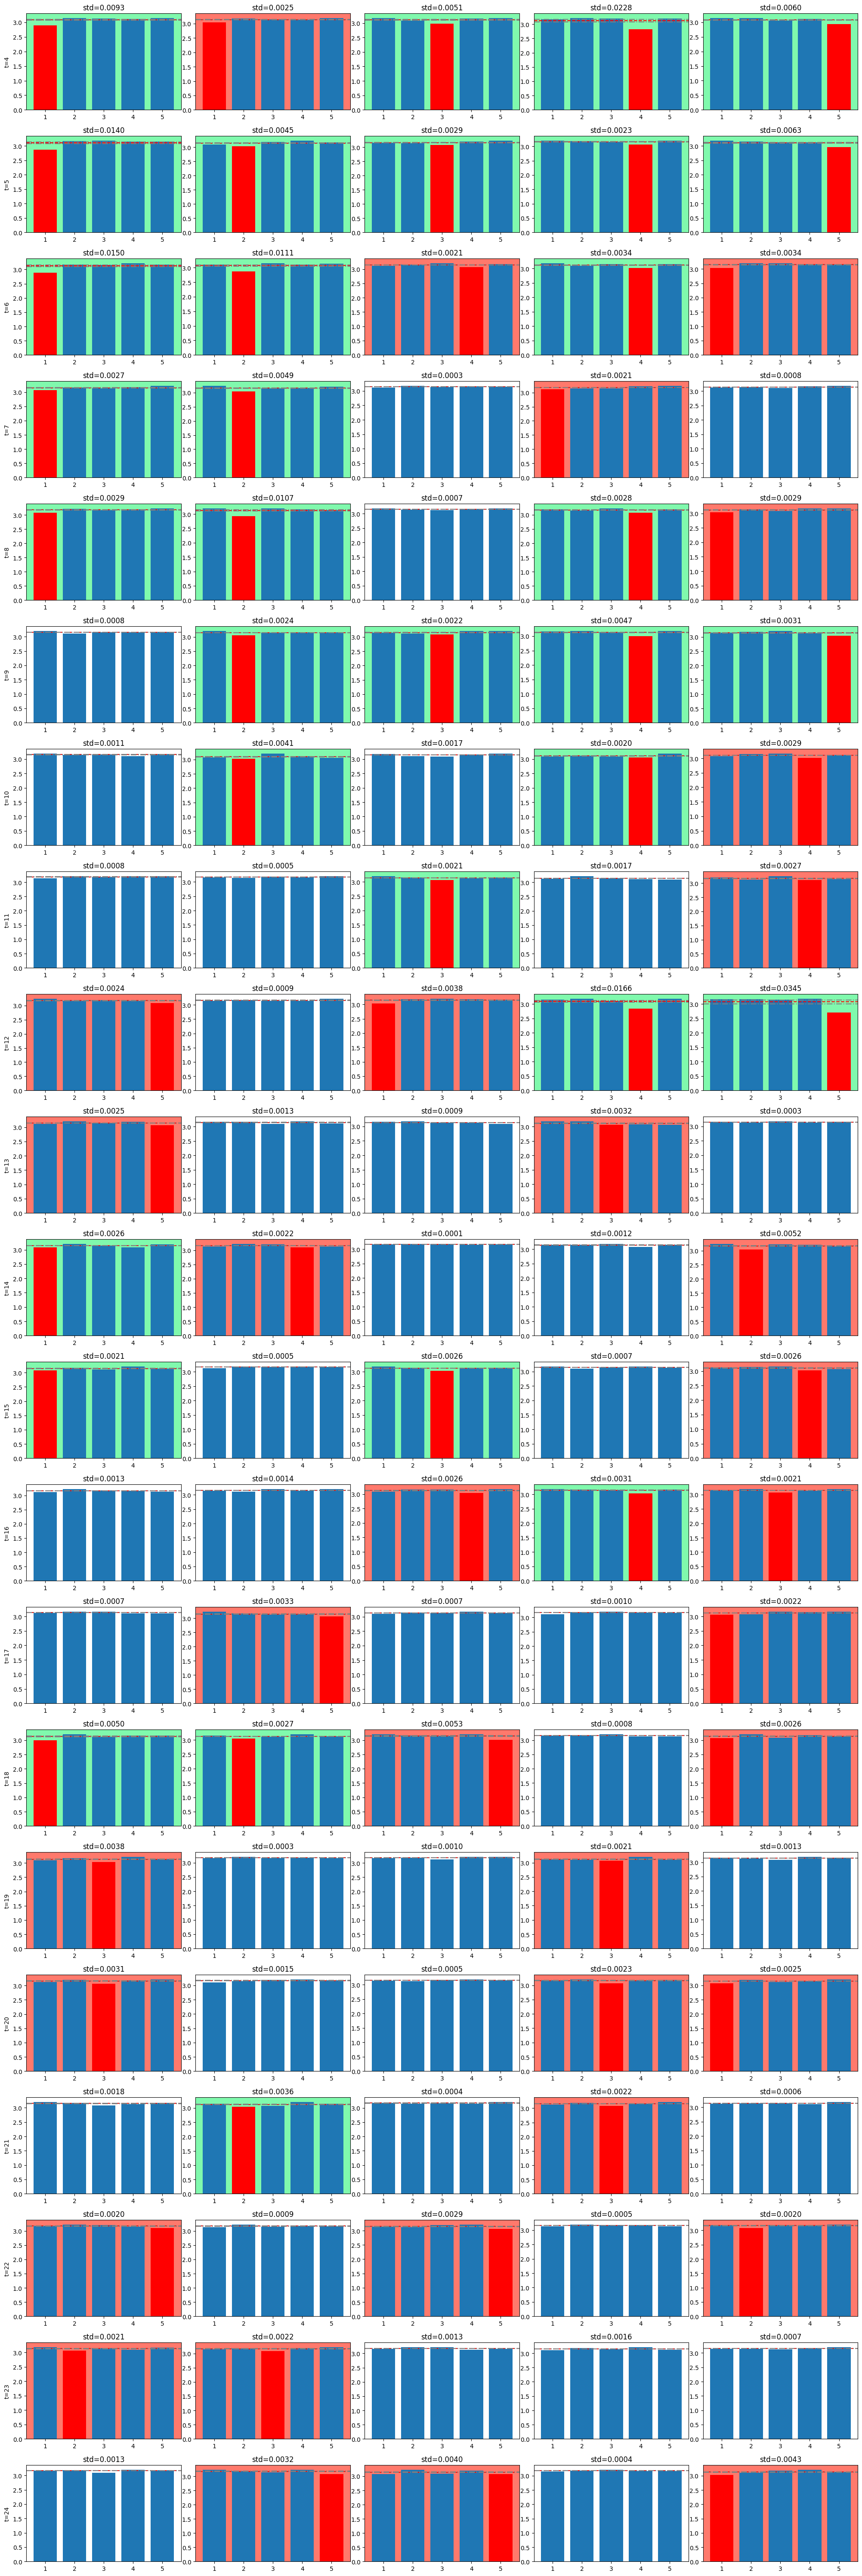

In [183]:
fig, axes = plt.subplots(len(keys), 5, figsize=(20, 60))

guessed_correctly = 0
guessed_wrongly = 0

for key in keys:
    k = key - 4
    ax_row = axes[key-4]
    ax_row[0].set_ylabel(f't={key}')
    for ci, ciphertext in enumerate(ciphers[key], 1):
        ax = ax_row[ci-1]
        guess = decrypt(ciphertext, search=100, threshold=0.002, ax=ax)
        if guess and guess == ci:
            guessed_correctly += 1
            ax.set_facecolor('xkcd:seafoam')
        if guess and guess != ci:
            guessed_wrongly += 1
            ax.set_facecolor('xkcd:salmon')

print('true positive', guessed_correctly / (len(keys) * 5) * 100)
print('false positive', guessed_wrongly / (len(keys) * 5) * 100)

plt.tight_layout()
plt.show()

In [17]:
@dataclass
class DecryptionResult:
    guess: int
    method: str

In [22]:
def trends_stats_test(ciphertext, plaintexts):
    entropy_trends = []
    for plaintext in plaintexts:
        _, Y = progressing_entropy_analysis(ciphertext, plaintext)
        entropy_trends.append(Y)

    diffs = []
    for i in range(len(entropy_trends)):
        for j in range(i + 1, len(entropy_trends)):
            trend_i = entropy_trends[i]
            trend_j = entropy_trends[j]
            diff = measure_trend_diff(trend_i, trend_j)
            diffs.append(diff)

    diff_avg = sum(diffs) / len(diffs)
    diff_var = sum((d - diff_avg) ** 2 for d in diffs) / len(diffs)
    diff_std = math.sqrt(diff_var)

    return diff_avg, diff_std, diffs, entropy_trends

def select_anomaly(entropy_trends, diffs, diff_avg, diff_std):
    anoms = []
    cs = combinations(range(len(entropy_trends)), 2)
    for (i, j), d in zip(cs, diffs):
        if d > diff_avg + 0.25 * diff_std:
            # smaller one is the anomaly
            if compare_trend(entropy_trends[i], entropy_trends[j]) > 0:
                anoms.append(j)
            else:
                anoms.append(i)
    
    print(f"[*] Anomaly indices: {anoms}")
    
    return anoms

def decrypt(ciphertext):
    diff_avg, diff_std, diffs, entropy_trends = trends_stats_test(ciphertext, plains)

    print("[*] Measure of difference between trends without any ciphertext modification")
    print(f"[*] Average: {diff_avg}")
    print(f"[*] Standard deviation: {diff_std}")

    if diff_std < ANOMALY_THRESHOLD:
        return DecryptionResult(
            guess=None,
            method="No anomaly found"
        )
    #     for n in range(1, int(SEARCH_SPACE * PROB)):
    #         for plaintext in plains:
    #             new_cipher = optimize_ciphertexts(ciphertext, plaintext, n)
    #             new_diff_avg, new_diff_std, new_diffs, _ = trends_stats_test(new_cipher, plains)
    #             if new_diff_std >= ANOMALY_THRESHOLD:
    #                 anoms = select_anomaly(entropy_trends, new_diffs, new_diff_avg, new_diff_std)
    #                 if anoms:
    #                     return DecryptionResult(
    #                         guess=Counter(anoms).most_common(1)[0][0] + 1,
    #                         method=f"Removed {n} chars from ciphertext"
                        # )

    anoms = []
    cs = combinations(range(len(entropy_trends)), 2)
    for (i, j), d in zip(cs, diffs):
        if d > diff_avg + 0.25 * diff_std:
            # smaller one is the anomaly
            if compare_trend(entropy_trends[i], entropy_trends[j]) > 0:
                anoms.append(j)
            else:
                anoms.append(i)

    if not anoms:
        return DecryptionResult(
            guess=None,
            method="Anomaly threshold touched, but no anomaly found"
        )

    guess = Counter(anoms).most_common(1)
    return DecryptionResult(
        guess=guess[0][0] + 1,
        method="Anomaly threshold touched, anomaly found"
    )

In [23]:
correct_cases = 0
total_cases = len(keys[:4]) * len(ciphers[4])
for k in keys[:4]:
    ciphertexts = ciphers[k]
    for i, cipher in enumerate(ciphertexts, 1):
        result = decrypt(cipher)
        if result.guess == i:
            correct_cases += 1
            print(f'{k}, {i}: O ({result.method})', flush=True)
        else:
            print(f'{k}, {i}: X ({result.guess}, {result.method})', flush=True)

print(f'Total testcases: {total_cases}')
print(f'Correct cases: {correct_cases}')
print(f'Accuracy: {correct_cases / total_cases * 100}')

[*] Measure of difference between trends without any ciphertext modification
[*] Average: 1.541881079553368
[*] Standard deviation: 1.7606439253279769
4, 1: O (Anomaly threshold touched, anomaly found)
[*] Measure of difference between trends without any ciphertext modification
[*] Average: 0.27316464832982607
[*] Standard deviation: 0.2397745549568368
4, 2: X (None, No anomaly found)
[*] Measure of difference between trends without any ciphertext modification
[*] Average: 0.08036128633194736
[*] Standard deviation: 0.05512466304751522
4, 3: X (None, No anomaly found)
[*] Measure of difference between trends without any ciphertext modification
[*] Average: 1.2508374599627785
[*] Standard deviation: 1.3924702409907344
4, 4: O (Anomaly threshold touched, anomaly found)
[*] Measure of difference between trends without any ciphertext modification
[*] Average: 0.09461407260916369
[*] Standard deviation: 0.06501640094981097
4, 5: X (None, No anomaly found)
[*] Measure of difference between t

# Progressing Entropy Analysis

## What is Entropy?

An entropy, or [information entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)),
is a measure of amount of information conveyed by an event.
An entropy may be interpreted as **surprise**, or **uncertainty**, because if an event is associated with a high entropy,
it implies something surprising or uncertain happened.

## What this analysis show?

First, we subtract a ciphertext with a plaintext. Then, we can observe the amount of shift applied to each character.

Let's take an example of (cipher_4, plain_1_4).

Because the encryption uses a key repeatedly, the shifts will be observed like:

```
2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, ...
```

It shows that shifts have a cyclic pattern.

However, if a random character inserted, the shifts will change drastically as follows:

```
2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 2, 3, 4, 1, 11, 26, 10, 15, 13, 26, 12,
```

Why?
It is because something surprising happend, which is a random character getting inserted, breaking the normal cyclic pattern.
In other words, we can observe an entropy increase.
It also implies the amount of information by observing the shifts surges up!

You can check this fact at the plots of `cipher_1`, `cipher_3` and `cipher_4` cases.
The matching cipher-plaintext pairs shows a differnt progressing trend (low at start, a steep increase at some point) in the cases.


## Why `cipher_2` and `cipher_5` cases are not working?

For this analysis to work, we need a following assumption:
the first `N` characters should show a cyclic pattern.

But, in `cipher_2` and `cipher_5` cases, the first `N` characters
do not show such pattern.
It is because a random character(s) is already inserted to the them.

How to solve?

- We can guess a good `N` (see below, or Kasiski examination)
- For the first `N` character,
    * try to delete a character
    * check whether a cyclic pattern shows up
        + entropy decreases or not
        + distances between same shifts
    * do this exhaustively

Since the problem is a random character in the first `N` character,
we recover the cyclic pattern of first `N` characters.


## How to know which `N` is good?

The proper `N` value will be a multiple of key length.
In this example, the ciphertexts are generated with a key of length 4,
thus `N` is set to 8.

To infer a key length, one can conduct a Kasiski examination,
to extract common factors of possible key lengths.


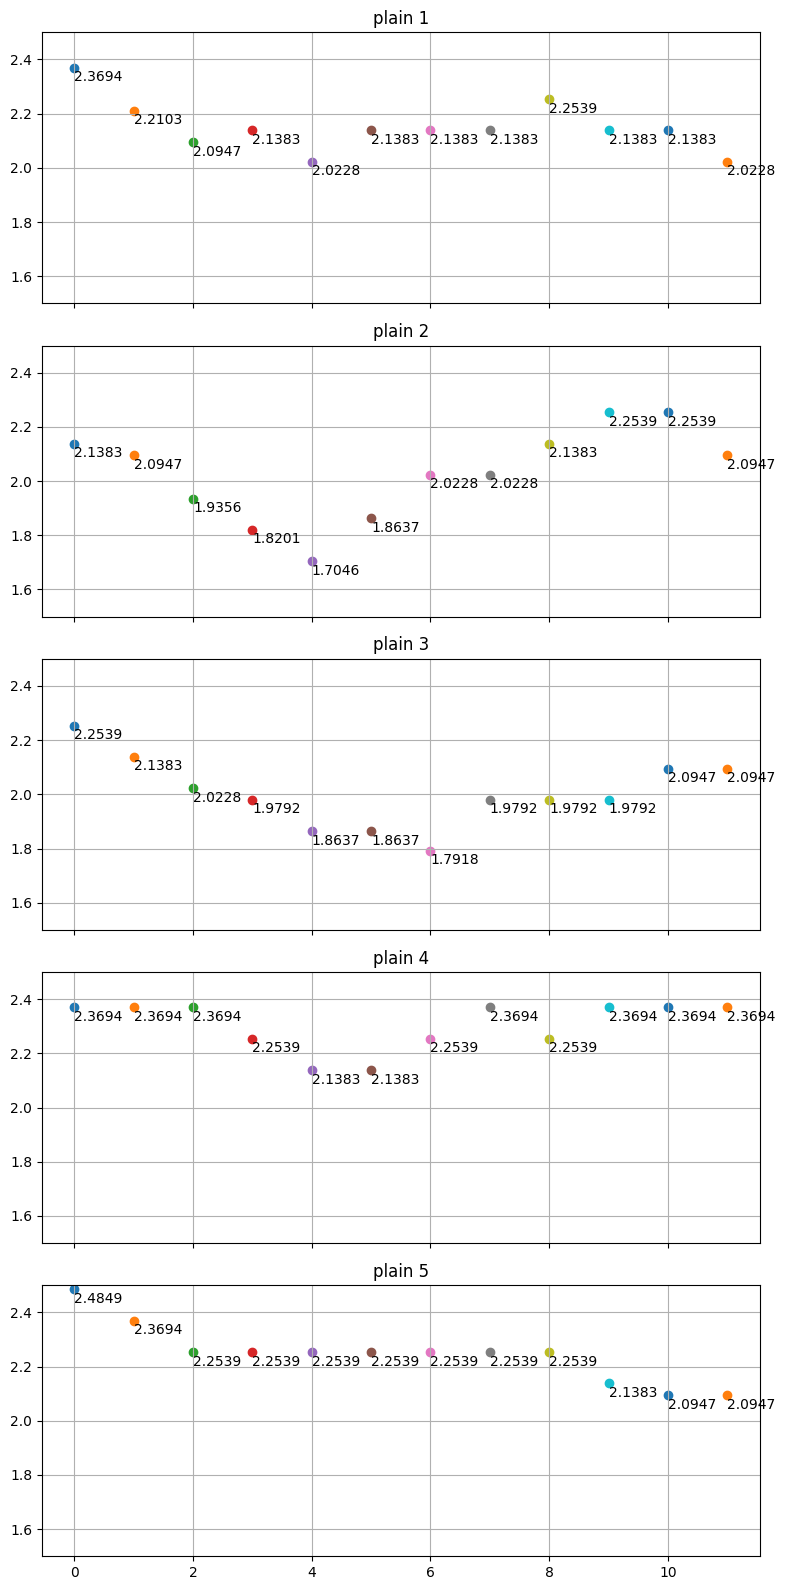

In [7]:
# Let's demonstrate a technique to recover the cyclic pattern in the first N characters

N = 12
ciphertext = cipher_2

fig, axes = plt.subplots(5, 1, sharex=True, figsize=(8, 16))

def select_cipher(i):
    return ciphertext[:i] + ciphertext[i+1:N+1]

for i, plaintext in enumerate(plains):
    plain_stream = encode(plaintext[:N])
    axes[i].set_ylim(1.5, 2.5)
    axes[i].grid()
    min_ent = float('inf')
    for j in range(N):
        ciphertext_j = select_cipher(j)
        cipher_stream = encode(ciphertext_j)
        diffs = [diff( i_c, i_p ) for i_c, i_p in zip(cipher_stream, plain_stream)]
        diff_counter = Counter(diffs)
        ent = entropy(diff_counter)
        if ent < min_ent:
            min_ent = ent
        axes[i].scatter(j, ent)
        axes[i].annotate(f'{ent:.4f}', (j, ent - 0.05))
    axes[i].set_title(f'plain {i+1}')

fig.tight_layout()

We can observe that, for the second plaintext,
if 4-th (0-indexed) character removed, the entropy is much lower than others.
Therefore, we can conclude that the removed character was a random character!

But, wait. The plain3 with 6th character removed case shows that entropy metric can wrongly indicate a cyclic pattern is restored! The entropy here is 1.7918, while the one of plain2 with 4th character removed is 1.7046. How close!

The entropy metric used indicates only how widely spread the distribution of shifts.
So, shifts such as `[4, 4, 4, 3, 3, 3, ...]` will have same entropy to `[4, 3, 4, 3, 4, 3, ...]`.
But, if we consider how the encryption is done, the latter one should have **LESS** entropy.

So, we have unanswered questions as below:

* How to encode positional information into the entropy metric?
* How to tell if an entropy is much lower than others? Using a threshold, or a ratio?

## Putting it all together

1. Progressing entropy analysis
    - If an anomaly observed, we can conclude which plaintext the ciphertext is encrypted from
    - Otherwise, we have to guess the random character position

In [28]:
def measure_trend_diff(pa, pb):
    return sum((a - b) ** 2 for a, b in zip(pa, pb))

def decrypt(ciphertext, end=16):
    progressing_ents = []
    for plaintext in plains:
        _, Y = progressing_entropy_analysis(ciphertext, plaintext, end=end)
        progressing_ents.append(Y)

    # examine if there is any anomaly
    cs = combinations(range(len(progressing_ents)), 2)
    ents_comb = combinations(progressing_ents, 2)
    ij_ents = list(zip(cs, ents_comb))
    diffs = []
    for (i, j), (pa, pb) in ij_ents:
        td = measure_trend_diff(pa, pb)
        diffs.append(td)
        # print(i,j, td)

    diff_avg = sum(diffs) / len(diffs)
    diff_var = sum((d - diff_avg) ** 2 for d in diffs) / len(diffs)
    diff_std = math.sqrt(diff_var)

    if diff_std < 0.8:
        print("Can't be determined by first N chars")
        return diffs, None

    anoms = []
    cs = combinations(range(len(progressing_ents)), 2)
    for (i, j), d in zip(cs, diffs):
        if d > diff_avg + 0.25 * diff_std:
            anoms.append(i)
            anoms.append(j)

    guess = Counter(anoms).most_common(1)
    if len(guess) == 0:
        return diffs, None
    return diffs, Counter(anoms).most_common(1)[0][0]


cipher_1 cracked

Can't be determined by first N chars
cipher_2 failed

cipher_3 cracked

cipher_4 cracked

Can't be determined by first N chars
cipher_5 failed



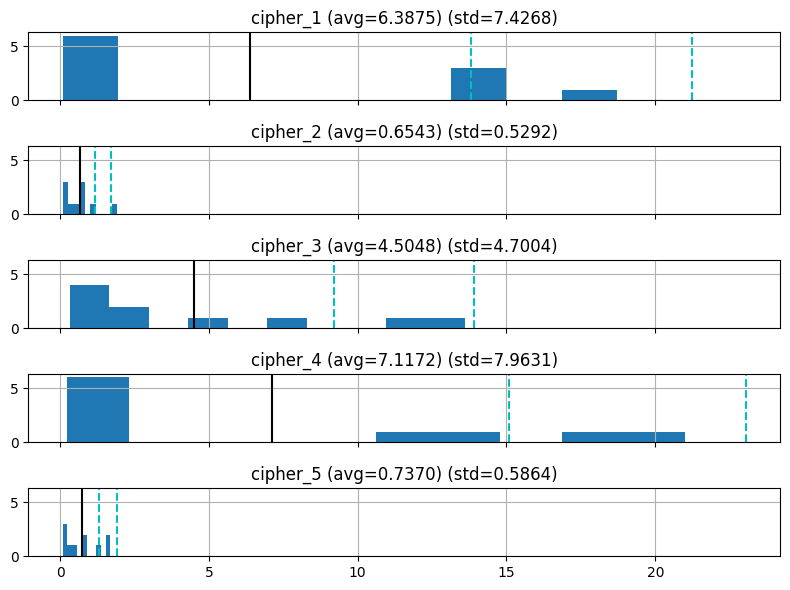

In [44]:
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True, sharey=True)

for i, ciphertext in enumerate(ciphers):
    diffs, guess = decrypt(ciphertext, end=12 * 2)
    diff_avg = sum(diffs) / len(diffs)
    diff_var = sum((d - diff_avg) ** 2 for d in diffs) / len(diffs)
    diff_std = math.sqrt(diff_var)
    axes[i].hist(diffs)
    axes[i].axvline(diff_avg, color='k', linestyle='-')
    axes[i].axvline(diff_avg + diff_std, color='c', linestyle='--')
    axes[i].axvline(diff_avg + diff_std * 2, color='c', linestyle='--')
    axes[i].grid()
    axes[i].set_title(f'cipher_{i+1} (avg={diff_avg:.4f}) (std={diff_std:.4f})')
    if guess is None:
        print(f'cipher_{i+1} failed\n')
        continue

    if guess == i:
        print(f'cipher_{i+1} cracked')
    else:
        print(f'cipher_{i+1} failed')
    print()

fig.tight_layout()

cipher_1 cracked

Can't be determined by first N chars
cipher_2 failed

cipher_3 cracked

cipher_4 cracked

Can't be determined by first N chars
cipher_5 failed



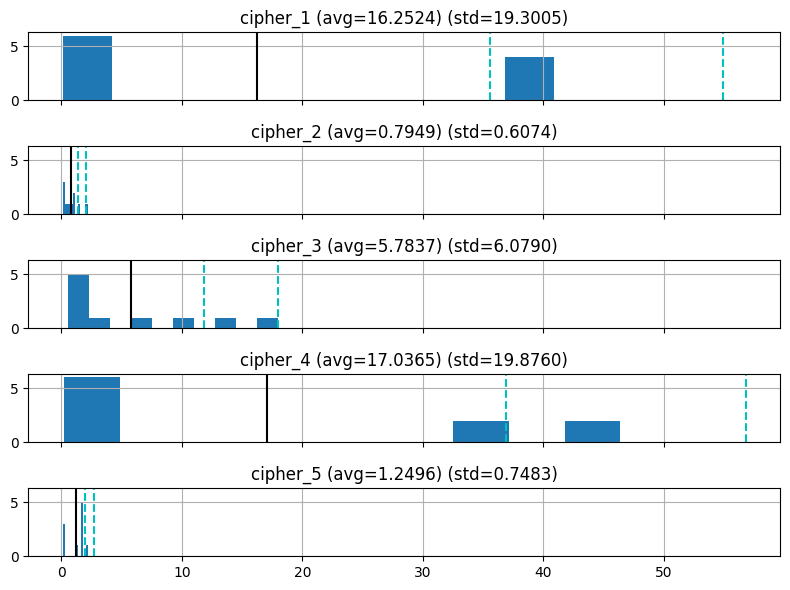

In [43]:
fig, axes = plt.subplots(5, 1, figsize=(8, 6), sharex=True, sharey=True)

for i, ciphertext in enumerate(ciphers):
    diffs, guess = decrypt(ciphertext, end=12 * 3)
    diff_avg = sum(diffs) / len(diffs)
    diff_var = sum((d - diff_avg) ** 2 for d in diffs) / len(diffs)
    diff_std = math.sqrt(diff_var)
    axes[i].hist(diffs)
    axes[i].axvline(diff_avg, color='k', linestyle='-')
    axes[i].axvline(diff_avg + diff_std, color='c', linestyle='--')
    axes[i].axvline(diff_avg + diff_std * 2, color='c', linestyle='--')
    axes[i].grid()
    axes[i].set_title(f'cipher_{i+1} (avg={diff_avg:.4f}) (std={diff_std:.4f})')
    if guess is None:
        print(f'cipher_{i+1} failed\n')
        continue

    if guess == i:
        print(f'cipher_{i+1} cracked')
    else:
        print(f'cipher_{i+1} failed')
    print()

fig.tight_layout()